# gtfSymbiois
***

v 0.0.2
by Samuel Rosean (samrosean@gmail.com)
***

## Introduction

To address concerns of transparency in current gtf merging tools we developed gtfSymbiosis. A toolset designed for combining, and deduplicating multiple gtf datasets, as well as comparing this resulting transcriptome against a reference annotation. gtfSymbiosis is intended to create a transparent process of deduplicating, and linking transcripts with user-defined thresholds for what constitutes a shared splice junction between transcripts, and what constitutes a matching start or stop site between transcripts.

***

## Setup GTF Symbiosis

First, we need to ensure the proper packages are imported, and that the gtfSymbiosis functions are defined.

#### Import Necessary Libraries

In [1]:
from gtfparse import read_gtf
import pandas as pd
import statistics
import numpy as np
import ensembl_rest
import random
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
from matplotlib_venn import venn3
from pywaffle import Waffle 
from prettytable import PrettyTable
import math
from matplotlib.gridspec import GridSpec
from copy import deepcopy
from collections import OrderedDict
from BCBio import GFF
from Bio import SeqIO
from itertools import combinations
from venn import venn
import networkx as nx
import itertools
from venn import pseudovenn
from upsetplot import from_contents
from upsetplot import plot
from upsetplot import generate_counts
import os
import seaborn as sns
import time
import collections
import pyranges as pr
from matplotlib.pyplot import figure
import gffpandas.gffpandas as gffpd

#### Ensure Our Dataframe Limits Are Usable

In [2]:
pd.options.display.max_columns = 500

### Current Function Definitions

Collapsed Returns (Returns transcripts and genes with a list of exons in those regions)

In [44]:
def collapsedReturns(givenGTF):
    
    ##givenGTF: A given gtf with exon rows that you wish to collapse into the transcript/gene rows
    
    ## The finale result will look like:
    
    ## feature   :   exons
    ##transcript :  [[124,456], [546, 789]]
    ## exon 1
    ## exon 2

    
    givenGTF['Exons'] = np.empty((len(givenGTF), 0)).tolist()
    counter = 0
    while counter < len(givenGTF.index):
        
        ##Collect the exons for each transcript
        exons = []
        if givenGTF.at[counter,"feature"] == "transcript" :
            itterator=1
            while counter+itterator < len(givenGTF.index) and givenGTF.at[counter+itterator,"feature"] != "transcript":
                if givenGTF.at[counter+itterator,"feature"] == "exon":
                    givenGTF.at[counter,"Exons"].append([givenGTF.at[counter+itterator,"start"],givenGTF.at[counter+itterator,"end"]])
                itterator=itterator+1
            counter = counter + itterator - 1
        else:
            counter=counter+1
    return(givenGTF)

Exon/Splice Junction Matching (returns a list of 0s and 1s coresponding to whether the exons/splice junctions in list1 match any exons/splice junctions in list2, takes a threshold value which determines how close they can be)

In [45]:
def exonMatching(list1, list2, threshold):
    
    ##list1: a list of exons or splice junctions to be matched
    ##list2: a list of exons or splice junctions to be matched
    ##threshold: how far the starts and stops can be to be considered a match
    
    itNum = len(list1)
    itNum2 = len(list2)
    listofzeroes = [0]*itNum
    itterator = 0
    itterator2 = 0
    while itterator < itNum:
        while itterator2 < itNum2 and list1[itterator][0] >= (list2[itterator2][1] + threshold):
            itterator2 = itterator2 + 1
        if itterator2 < itNum2 and abs(list1[itterator][1] - list2[itterator2][1]) <= threshold and abs(list1[itterator][0] - list2[itterator2][0]) <= threshold:
            listofzeroes[itterator] = 1
            itterator = itterator + 1
        else:
            itterator = itterator + 1
            
    return(listofzeroes)

Splice Junction Column Creator (creates a column containing the splice junction data based off of the exon column)

In [46]:
def splicJuncColumn(givenGTF):
    
    ##givenGTF: a dataframe which has already been collapsed
    
    givenGTF['Splice_Junctions'] = np.empty((len(givenGTF), 0)).tolist()
    for index, row in givenGTF.iterrows():
        if not givenGTF.at[index,"Exons"]:
            pass
        else:
            if len(givenGTF.at[index,"Exons"]) == 1:
                pass
            elif len(givenGTF.at[index,"Exons"]) > 1:
                i = 0
                while i < len(givenGTF.at[index,"Exons"]) - 1:
                    start = givenGTF.at[index,"Exons"][i][1]
                    end = givenGTF.at[index,"Exons"][i+1][0]
                    givenGTF.at[index,"Splice_Junctions"].append([start,end])
                    i = i + 1
            
    return(givenGTF)

ReFormat For Exporting (Recreate the Exon Columns)

In [47]:
def reformatExons(startFrame):
    
    ##startFrame: the collapsed dataframe that you wish to create the exon rows for
    
    endFrame = pd.DataFrame()
    
     ###Create an array of each GTFs chromosones
    chromosones1 = startFrame.seqname.unique().tolist()
    
    mtLoc= False
    if 'MT' in chromosones1:
        mtLoc = True
        
    if 'X' in chromosones1:
        chromosones1.remove('X')
    if 'Y' in chromosones1:
        chromosones1.remove('Y')
    if mtLoc == True:
        chromosones1.remove('MT')
    
    chromosones2 = list(map(int, chromosones1))
    
    chromosones2.sort()
    
    chromosones2.append('X')
    chromosones2.append('Y')
    if mtLoc == True:
        chromosones2.append('MT')
    
    chromosones2 = list(map(str, chromosones2))
    
    for item in chromosones2:
        
        chromeFrame = pd.DataFrame()
        runFrame = startFrame[startFrame["seqname"] == item]
        runFrame = runFrame.reset_index()
        runFrame = runFrame.drop(columns=['index'])
        
        if item == "MT":
            for index, row in runFrame.iterrows():
                runFrame.at[index, "start"] = runFrame.at[index, "Exons"][0][0]
                runFrame.at[index, "end"] = runFrame.at[index, "Exons"][len(runFrame.at[index, "Exons"])-1][1]
        
        for index, row in runFrame.iterrows():
            
            row1 = runFrame.iloc[index]
            rowFrame = pd.DataFrame(row1)
            rowFrame = rowFrame.T
            
            rowFrame = rowFrame.reset_index()
            rowFrame = rowFrame.drop(columns=['index'])
        
            tempFrame = pd.DataFrame()
            k=1
            if rowFrame.at[0,"strand"] == "+":
                for itemExon in rowFrame.at[0,"Exons"]:
                    newRow = pd.DataFrame([[rowFrame.at[0,"seqname"],rowFrame.at[0,"source"],"exon", itemExon[0], itemExon[1], rowFrame.at[0,"score"], rowFrame.at[0,"strand"], rowFrame.at[0,"frame"], rowFrame.at[0,"gene_id"], rowFrame.at[0,"transcript_id"] , k]], columns=['seqname','source','feature', 'start', 'end', 'score', 'strand', 'frame', 'gene_id', 'transcript_id', 'exon_id'])
                    tempFrame = pd.concat([tempFrame, newRow])
                    k = k + 1
            elif rowFrame.at[0,"strand"] == "-":
                for itemExon in reversed(rowFrame.at[0,"Exons"]):
                    newRow = pd.DataFrame([[rowFrame.at[0,"seqname"],rowFrame.at[0,"source"],"exon", itemExon[0], itemExon[1], rowFrame.at[0,"score"], rowFrame.at[0,"strand"], rowFrame.at[0,"frame"], rowFrame.at[0,"gene_id"], rowFrame.at[0,"transcript_id"] , k]], columns=['seqname','source','feature', 'start', 'end', 'score', 'strand', 'frame', 'gene_id', 'transcript_id', 'exon_id'])
                    tempFrame = pd.concat([tempFrame, newRow])
                    k = k + 1

            rowFrame = pd.concat([rowFrame, tempFrame])
            chromeFrame = pd.concat([chromeFrame, rowFrame])
        
        endFrame = pd.concat([endFrame, chromeFrame ])
        print(item, end=" ")
        
    endFrame = endFrame.reset_index()
    endFrame = endFrame.drop(columns=['index'])
    
    return(endFrame)

Write as GTF File (write a dataframe as a gtf file)

In [48]:
def writeGTF(name, givenGTF, extraColumns = True):
    
    ##name: the filename you wish to write the reuslt as
    ##givenGTF: the dataframe you wish to print as a gtf
    ##extraColumns: a flag to indicate whether you wish to print more than the basic 11 columns (true will print the extra columns)
    
    correctColumns = ["seqname", "source", "feature", "start", "end", "score", "strand", "frame", "gene_id", "transcript_id", "exon_id" ]
    
    if extraColumns == True:
        givenColList = givenGTF.columns.tolist()
        extraCol = []

        for item in givenColList:
            if item not in correctColumns:
                extraCol.append(item)

        correctColumns.extend(extraCol)
    
    givenGTF = givenGTF[correctColumns]
    
    with open(name,'w') as fh:
        for index, row in givenGTF.iterrows():
            string = ""
            k = 0
            
            for column in givenGTF:
                if k <= 7:
                    k = k + 1
                    string = string + str(givenGTF.at[index, column]) + "\t"
                elif (str(column) == "gene_id") or (str(column) == "transcript_id") or (str(column) == "transcript_name"):
                        k = k + 1
                        string = string + str(column) + " " + "\"" + str(givenGTF.at[index, column]) + "\"" + "; "
                elif extraColumns == True:
                    k = k + 1
                    string = string + str(column) + " " + "\"" + str(givenGTF.at[index, column]) + "\"" + "; "

            
            string = string + "\n"
            fh.write(string)


Smaller or Larger Compared To Reference (a function to characterize and compare how a transcript compares to a reference, wether transcripts are on average smaller or larger)

In [57]:
def smallLarger(givenGTF, exonThreshold):
    
    ##givenGTF: a gtf which has been comapred to a reference which you wish to characterize
    ##exonThreshold: how much larger does a read have to be compared to another to be considered a "larger" transcript, and vice versa for "smaller"
    
    ##get the change in start and stop for perfect matches to annotation
    perfectEnds = []
    perfectStarts = []
    
    for index, row in givenGTF.iterrows():
        
        ##if theres a perfect match then add the starts and stops to the perfect match value
        for item in givenGTF.at[index, 'Matched_Ref_Start_Stop']:
            
            ##flip values if on negative strand
            if givenGTF.at[index, 'strand'] == "-":
                perfectEnds.append(-item[0])
                perfectStarts.append(item[1])
            else:
                perfectStarts.append(-item[0])
                perfectEnds.append(item[1])
                
        #if not a perfect match, but all splice junctions match, also add it to the perfect start and stop values
        for item in givenGTF.at[index, 'Shared_Ref_Weight']:
            matchedLen = len(givenGTF.at[index, 'Exons'])
            refLen = len(item[0])

            if ((matchedLen-refLen)==0) & (sum(item[2])==matchedLen):
                
                if givenGTF.at[index, 'strand'] == "-":
                    perfectEnds.append(item[1][0] - givenGTF.at[index, 'start'])
                    perfectStarts.append(givenGTF.at[index, 'end'] - item[1][1])
                else:
                    perfectStarts.append(item[1][0] - givenGTF.at[index, 'start'])
                    perfectEnds.append(givenGTF.at[index, 'end'] - item[1][1])
                
    ##Create a table with this data
    perfectsiteData = [perfectEnds, perfectStarts]
    perfectsiteTypes = ["Change in End Site", "Change in Start Site"]
    fullPFrame = pd.DataFrame()
    for i in range(len(perfectsiteData)):
        loopFrame = pd.DataFrame(perfectsiteData[i])
        loopFrame["Site Type"] = perfectsiteTypes[i]
        fullPFrame = fullPFrame.append(loopFrame)
    
    
    ##change column name to be base pair change
    fullPFrame = fullPFrame.rename(columns={0: "Base Pair Change"})
    
    #plt.figure(figsize=(20, 10))
    #sns.set(font_scale=2)
    #ax = sns.violinplot(x= "Site Type", y="Base Pair Change", data=fullPFrame, inner="quartile")
    
    #plt.show()
    
    
    #Select a gtf with only partial matches
    matchGTF  = givenGTF[givenGTF.astype(str)['Shared_Ref_Weight'] != '[]']
    
    #select a gtf with only multiple partial matches
    multipleMatchGTF = matchGTF[matchGTF['Shared_Ref_Weight'].str.len() > 1]
    
    #select a gtf with only single partial matches
    singleMatchGTF = matchGTF[matchGTF['Shared_Ref_Weight'].str.len() == 1]
    
    #add a column of how many matches each transcript has
    matchGTF['Length'] = matchGTF['Shared_Ref_Weight'].str.len()
    
    #get an avergae amount of these matches
    averageNumberMatches = matchGTF["Length"].mean()
    
    #reset index to loop through the single match gtf
    singleMatchGTF = singleMatchGTF.reset_index()
    singleMatchGTF = singleMatchGTF.drop(columns=['index'])
    
    #Get the size of all of these gtfs
    readCounts = matchGTF.shape[0]
    multipleMatchCount = multipleMatchGTF.shape[0]
    singleMatchCount = singleMatchGTF.shape[0]
    
    #print table of results up until now
    t = PrettyTable(['Name', 'Amount', 'Percent'])
    t.add_row(['Total Transcripts With Partial Matches To Reference', readCounts, 100])
    t.add_row(['Transcripts With Multiple Partial Matches', multipleMatchCount, round(((multipleMatchCount)/readCounts)*100, 2)])
    t.add_row(['Transcripts With A Single Partial Match', singleMatchCount, round(((singleMatchCount)/readCounts)*100, 2)])
    t.add_row(['Average # of Matches (For Transcripts With Partial Matches to Reference)', round(averageNumberMatches,2), "N/A"])
    print("\n")
    print(t)

    print("From this point on only single partial match transcripts will be used.")
    
    #create values for counts and list to contain differences of exons past or before reference read
    startBigger = 0
    startSmaller = 0
    startSame = 0
    
    endBigger = 0
    endSmaller = 0
    endSame = 0

    
    endChange = []
    startChange = []
    
    #create values for counts and list to contain differences
    #Size of the single matches
    totalCount = singleMatchCount
    
    #counts and lists for exon differences
    longer = 0
    shorter = 0
    same = 0
    sameExonMatch = 0
    sameExonChange = 0
    exonChange = []
    
    endLengthLonger = 0
    endLengthShorter = 0
    endLengthSame = 0
    
    endLongerSameExon = 0
    endLongerDiffExon = 0
    endShorterSameExon = 0
    endShorterDiffExon = 0
    endSameSameExon = 0
    endSameDiffExon = 0
    
    startLengthLonger = 0
    startLengthShorter = 0
    startLengthSame = 0
    
    startLongerSameExon = 0
    startLongerDiffExon = 0
    startShorterSameExon = 0
    startShorterDiffExon = 0
    startSameSameExon = 0
    startSameDiffExon = 0
    
    zeroExon = []
    zeroExon2 = []
    
    
    
    for index, row in singleMatchGTF.iterrows():
        for item in singleMatchGTF.at[index, 'Shared_Ref_Weight']:
            matchedLen = len(singleMatchGTF.at[index, 'Exons'])
            refLen = len(item[0])
            
            
            ##catalog change in exon numbers
            exonChange.append(matchedLen-refLen)
            if matchedLen > refLen:
                longer = longer + 1
            elif matchedLen < refLen:
                shorter = shorter + 1
            elif matchedLen==refLen:
                same = same + 1
                if sum(item[2]) == matchedLen-1:
                    sameExonMatch = sameExonMatch + 1
                else:
                    sameExonChange = sameExonChange + 1
            
            ##Catalog changes in length
            if singleMatchGTF.at[index, 'strand'] == "-":
                
                tempEnd = item[1][0] - singleMatchGTF.at[index, 'start']
                tempStart = singleMatchGTF.at[index, 'end'] - item[1][1]
                endChange.append(item[1][0] - singleMatchGTF.at[index, 'start'])
                startChange.append(singleMatchGTF.at[index, 'end'] - item[1][1])
                
                if tempEnd > 0:
                    endLengthLonger = endLengthLonger + 1
                    if matchedLen==refLen:
                        if sum(item[2]) == matchedLen-1:
                            endLongerSameExon = endLongerSameExon + 1
                        else:
                            endLongerDiffExon = endLongerDiffExon + 1
                    else:
                        endLongerDiffExon = endLongerDiffExon + 1
                
                if tempEnd < 0:
                    endLengthShorter = endLengthShorter + 1
                    if matchedLen==refLen:
                        if sum(item[2]) == matchedLen-1:
                            endShorterSameExon = endShorterSameExon + 1
                        else:
                            endShorterDiffExon = endShorterDiffExon + 1
                    else:
                        endShorterDiffExon = endShorterDiffExon + 1
                        
                if tempEnd == 0:
                    endLengthSame = endLengthSame +1
                    if matchedLen==refLen:
                        if sum(item[2]) == matchedLen-1:
                            endSameSameExon = endSameSameExon + 1
                        else:
                            endSameDiffExon = endSameDiffExon + 1
                    else:
                        endSameDiffExon = endSameDiffExon + 1
                        
                if tempStart > 0:
                    startLengthLonger = startLengthLonger + 1
                    if matchedLen==refLen:
                        if sum(item[2]) == matchedLen-1:
                            startLongerSameExon = startLongerSameExon + 1
                        else:
                            startLongerDiffExon = startLongerDiffExon + 1
                    else:
                        startLongerDiffExon = startLongerDiffExon + 1
                
                if tempStart < 0:
                    startLengthShorter = startLengthShorter + 1
                    if matchedLen==refLen:
                        if sum(item[2]) == matchedLen-1:
                            startShorterSameExon = startShorterSameExon + 1
                        else:
                            startShorterDiffExon = startShorterDiffExon + 1 
                    else:
                        startShorterDiffExon = startShorterDiffExon + 1   
                
                if tempStart == 0:
                    startLengthSame = startLengthSame + 1
                    if matchedLen==refLen:
                        if sum(item[2]) == matchedLen-1:
                            startSameSameExon = startSameSameExon + 1
                        else:
                            startSameDiffExon = startSameDiffExon + 1
                    else:
                        startSameDiffExon = startSameDiffExon + 1
                    
            else:
                tempStart = item[1][0] - singleMatchGTF.at[index, 'start']
                tempEnd = singleMatchGTF.at[index, 'end'] - item[1][1]
                startChange.append(item[1][0] - singleMatchGTF.at[index, 'start'])
                endChange.append(singleMatchGTF.at[index, 'end'] - item[1][1])
                
                if tempEnd > 0:
                    endLengthLonger = endLengthLonger + 1
                    if matchedLen==refLen:
                        if sum(item[2]) == matchedLen-1:
                            endLongerSameExon = endLongerSameExon + 1
                        else:
                            endLongerDiffExon = endLongerDiffExon + 1
                    else:
                        endLongerDiffExon = endLongerDiffExon + 1
                
                if tempEnd < 0:
                    endLengthShorter = endLengthShorter + 1
                    if matchedLen==refLen:
                        if sum(item[2]) == matchedLen-1:
                            endShorterSameExon = endShorterSameExon + 1
                        else:
                            endShorterDiffExon = endShorterDiffExon + 1
                    else:
                        endShorterDiffExon = endShorterDiffExon + 1
                        
                if tempEnd == 0:
                    endLengthSame = endLengthSame +1
                    if matchedLen==refLen:
                        if sum(item[2]) == matchedLen-1:
                            endSameSameExon = endSameSameExon + 1
                        else:
                            endSameDiffExon = endSameDiffExon + 1
                    else:
                        endSameDiffExon = endSameDiffExon + 1
                        
                if tempStart > 0:
                    startLengthLonger = startLengthLonger + 1
                    if matchedLen==refLen:
                        if sum(item[2]) == matchedLen-1:
                            startLongerSameExon = startLongerSameExon + 1
                        else:
                            startLongerDiffExon = startLongerDiffExon + 1
                    else:
                        startLongerDiffExon = startLongerDiffExon + 1
                
                if tempStart < 0:
                    startLengthShorter = startLengthShorter + 1
                    if matchedLen==refLen:
                        if sum(item[2]) == matchedLen-1:
                            startShorterSameExon = startShorterSameExon + 1
                        else:
                            startShorterDiffExon = startShorterDiffExon + 1 
                    else:
                        startShorterDiffExon = startShorterDiffExon + 1   
                
                if tempStart == 0:
                    startLengthSame = startLengthSame + 1
                    if matchedLen==refLen:
                        if sum(item[2]) == matchedLen-1:
                            startSameSameExon = startSameSameExon + 1
                        else:
                            startSameDiffExon = startSameDiffExon + 1
                    else:
                        startSameDiffExon = startSameDiffExon + 1
            
            
            ##Catolog change in exon locations
            if (item[0][0][0] - singleMatchGTF.at[index, 'Exons'][0][1] >= exonThreshold):
                if singleMatchGTF.at[index, 'strand'] == "-":
                    endBigger = endBigger+1
                else:
                    startBigger = startBigger+1
                    
            elif (singleMatchGTF.at[index, 'Exons'][0][0] - item[0][0][1] >= exonThreshold):
                if singleMatchGTF.at[index, 'strand'] == "-":
                    endSmaller = endSmaller+1
                else:
                    startSmaller = startSmaller+1
            else:
                if singleMatchGTF.at[index, 'strand'] == "-":
                    endSame = endSame+1
                else:
                    startSame = startSame+1
                    
            if (singleMatchGTF.at[index, 'Exons'][matchedLen-1][0] - item[0][refLen-1][1]>= exonThreshold):
                if singleMatchGTF.at[index, 'strand'] == "-":
                    startBigger = startBigger+1
                else:
                    endBigger = endBigger+1
                    
            elif (item[0][refLen-1][0] - singleMatchGTF.at[index, 'Exons'][matchedLen-1][1] >= exonThreshold):
                if singleMatchGTF.at[index, 'strand'] == "-":
                    startSmaller = startSmaller+1
                else:
                    endSmaller = endSmaller+1
                    
            else:
                if singleMatchGTF.at[index, 'strand'] == "-":
                    startSame = startSame+1
                else:
                    endSame = endSame+1
                    
    #Print another table of the results so far                
    t = PrettyTable(['Name', 'Amount', 'Percent'])
    t.add_row(['Total Partial Matches', totalCount, 100])
    t.add_row(['More Exons (Count)', longer, round(((longer)/totalCount)*100, 3)])
    t.add_row(['Less Exons (Count)', shorter, round(((shorter)/totalCount)*100, 3)])
    t.add_row(['Same Exons (Count)', same, round(((same)/totalCount)*100, 3)])
    t.add_row(['Same Exons (Same Splice Junctions (Count))', sameExonMatch, round(((sameExonMatch)/totalCount)*100, 3)])
    t.add_row(['Same Exons (Diff Splice Junctions (Count))', sameExonChange, round(((sameExonChange)/totalCount)*100, 3)])
    print("\n")
    print(t)
    
    t = PrettyTable(['Name', 'Amount', 'Percent'])
    t.add_row(['Total Partial Matches', totalCount, 100])
    t.add_row(['Longer End (Count)', endLengthLonger, round(((endLengthLonger)/totalCount)*100, 3)])
    t.add_row(['Longer End (Same Splice Junctions) (Count)', endLongerSameExon, round(((endLongerSameExon)/totalCount)*100, 3)])
    t.add_row(['Longer End (Diff Splice Junctions) (Count)', endLongerDiffExon, round(((endLongerDiffExon)/totalCount)*100, 3)])
    t.add_row(['Shorter End (Count)', endLengthShorter, round(((endLengthShorter)/totalCount)*100, 3)])
    t.add_row(['Shorter End (Same Splice Junctions (Count))', endShorterSameExon, round(((endShorterSameExon)/totalCount)*100, 3)])
    t.add_row(['Shorter End (Diff Splice Junctions (Count))', endShorterDiffExon, round(((endShorterDiffExon)/totalCount)*100, 3)])
    t.add_row(['Same End (Count)', endLengthSame, round(((endLengthSame)/totalCount)*100, 3)])
    t.add_row(['Same End (Same Splice Junctions (Count))', endSameSameExon, round(((endSameSameExon)/totalCount)*100, 3)])
    t.add_row(['Same End (Diff Splice Junctions (Count))', endSameDiffExon, round(((endSameDiffExon)/totalCount)*100, 3)])
    print("\n")
    print(t)
    
    t = PrettyTable(['Name', 'Amount', 'Percent'])
    t.add_row(['Total Partial Matches', totalCount, 100])
    t.add_row(['Longer Start (Count)', startLengthLonger, round(((startLengthLonger)/totalCount)*100, 3)])
    t.add_row(['Longer Start (Same Splice Junctions) (Count)', startLongerSameExon, round(((startLongerSameExon)/totalCount)*100, 3)])
    t.add_row(['Longer Start (Diff Splice Junctions) (Count)', startLongerDiffExon, round(((startLongerDiffExon)/totalCount)*100, 3)])
    t.add_row(['Shorter Start (Count)', startLengthShorter, round(((startLengthShorter)/totalCount)*100, 3)])
    t.add_row(['Shorter Start (Same Splice Junctions (Count))', startShorterSameExon, round(((startShorterSameExon)/totalCount)*100, 3)])
    t.add_row(['Shorter Start (Diff Splice Junctions (Count))', startShorterDiffExon, round(((startShorterDiffExon)/totalCount)*100, 3)])
    t.add_row(['Same Start (Count)', startLengthSame, round(((startLengthSame)/totalCount)*100, 3)])
    t.add_row(['Same Start (Same Splice Junctions (Count))', startSameSameExon, round(((startSameSameExon)/totalCount)*100, 3)])
    t.add_row(['Same Start (Diff Splice Junctions (Count))', startSameDiffExon, round(((startSameDiffExon)/totalCount)*100, 3)])
    print("\n")
    print(t)
    
    t = PrettyTable(['Name', 'Amount', 'Percent'])
    t.add_row(['Longer End (Exon Past Reference Read End)', endBigger, round(((endBigger)/totalCount)*100, 3)])
    t.add_row(['Shorter End (Refernce Exon Past Read End)', endSmaller, round(((endSmaller)/totalCount)*100, 3)])
    t.add_row(['Same End (No Exon Past Reference End or Reference Exon Past Read End)', endSame, round(((endSame)/totalCount)*100, 3)])
    t.add_row(['Longer Start (Exon Past Reference Read Start)', startBigger, round(((startBigger)/totalCount)*100, 3)])
    t.add_row(['Shorter Start (Refernce Exon Past Read Start)', startSmaller, round(((startSmaller)/totalCount)*100, 3)])
    t.add_row(['Same Start (No Exon Past Reference Start or Reference Exon Past Read Start)', startSame, round(((startSame)/totalCount)*100, 3)])
    print("\n")
    print(t)
    
    print("\n")
    
    print("Overall Exon Change Analysis:")
    
    print("\n")
    
    print("max exon change:", max(exonChange))
    print("min exon change:", min(exonChange))
    
    exondf = pd.DataFrame(exonChange)
    
    exonQuant = exondf[0].quantile([.1, .25, .5, .75, .9])
    
    print("Exon Change Quantitles:")
    print(exonQuant)
    
    
    plt.figure(figsize=(20, 10))
    sns.set(font_scale=2)
    ax = sns.violinplot(data=exonChange, inner="quartile") 
    
    plt.ylim(-40, 40)
    
    plt.show()
    
    print("\n")
    
    print("Overall Start and Stop Change Analysis:")
    
    print("\n")
    
    print("max start change:", max(startChange))
    print("min start change:", min(startChange))
    
    print("max end change:", max(endChange))
    print("min end change:", min(endChange))
    
    
    siteData = [endChange, startChange]
    siteTypes = ["Difference in End Site", "Difference in Start Site"]
    fullSFrame = pd.DataFrame()
    for i in range(len(siteData)):
        loopFrame = pd.DataFrame(siteData[i])
        loopFrame["Site Type"] = siteTypes[i]
        fullSFrame = fullSFrame.append(loopFrame)

    fullSFrame = fullSFrame.rename(columns={0: "# of Base Pair Difference"})
    
    plt.figure(figsize=(20, 10))
    sns.set(font_scale=2)
    ax = sns.violinplot(x= "Site Type", y="Base Pair Change", data=fullSFrame, inner="quartile")
    
    plt.show()
    
            

Find Fusion Genes

In [50]:
def findFusionGenes(matchedTranscriptome, referenceTranscriptome):
    
    ###Check if any of our generated transcriptome genes span multiple genes from the reference transcriptome (reuqires that gtfTranscriptme was ran with a reference transcriptome)
    ##matchedTranscriptome - the transcriptome returned from the gtfTranscriptome function
    ##referenceTranscriptome - the transcriptome we used to align the gtf originally (though this isnt needed to see multiple genes are spanned by an iso-seq gene, we use it to get the start and stops, as well as strands of the ensembl genes)
    
    #get only the transcripts from our reference transcriptome
    referenceTranscripts = referenceTranscriptome[referenceTranscriptome["feature"]=="transcript"]

    matchedTranscriptome[matchedTranscriptome["Matched_Reference_Gene"] != "[]"]
    
    ##create dictionary of every iso-seq gene
    lengthGeneNames = len(list(set(matchedTranscriptome["gene_id"])))
    geneDict = {}
    
    for item in list(set(matchedTranscriptome["gene_id"])):
        geneDict[item] = []
    
    #Add Each connection from our data
    for index, row in matchedTranscriptome.iterrows():
        for item in matchedTranscriptome.at[index, "Matched_Reference_Gene"]:
            if item is not None:
                geneDict[matchedTranscriptome.at[index, "gene_id"]].append(item)
                geneDict[matchedTranscriptome.at[index, "gene_id"]] = list(set(geneDict[matchedTranscriptome.at[index, "gene_id"]]))
             
    #find the fusion genes
    fusionGene = {}
    for key in geneDict:
        if len(geneDict[key]) > 1:
            fusionGene[key] = geneDict[key]
            
    isoValues = list(fusionGene.keys())
    ensemblValues = list(fusionGene.values())
    
    ##begin gathering the other needed data from our fusion gene results
    dfPract = pd.DataFrame(columns = ["iso", "reference_genes"])
    dfPract["iso"] = isoValues
    dfPract["reference_genes"] = ensemblValues
    dfPract["strand"] = None
    dfPract["chr"] = None
    dfPract["Splice_Junctions"] = np.empty((len(dfPract), 0)).tolist()
    dfPract["start"] = None
    dfPract["end"] = None
    dfPract['ref_location'] = np.empty((len(dfPract), 0)).tolist()
    dfPract['ref_chrs'] = np.empty((len(dfPract), 0)).tolist()
    dfPract['ref_strands'] = np.empty((len(dfPract), 0)).tolist()
    dfPract['overlap'] = False
    
    ##for each fusion gene collect that needed data
    for index, row in dfPract.iterrows():
        
        ##add the smallest start and the largest end
        dfPract.at[index, "start"] = min(list(matchedTranscriptome[matchedTranscriptome["gene_id"] == dfPract.at[index, "iso"]]["start"]))
        dfPract.at[index, "end"] = max(list(matchedTranscriptome[matchedTranscriptome["gene_id"] == dfPract.at[index, "iso"]]["end"]))
        
        ##add every uniqe strand and chr in the gene set to see if any cross chromosone or strand results are occuring
        dfPract.at[index, "chr"] = list(set(list(matchedTranscriptome[matchedTranscriptome["gene_id"] == dfPract.at[index, "iso"]]["seqname"])))
        dfPract.at[index, "strand"] = list(set(list(matchedTranscriptome[matchedTranscriptome["gene_id"] == dfPract.at[index, "iso"]]["strand"])))
        
        ##get all splice junctions and then flatten the list
        sjList = list(matchedTranscriptome[matchedTranscriptome["gene_id"] == dfPract.at[index, "iso"]]["Splice_Junctions"])
        sjList = [item for sublist in sjList for item in sublist]
        
        ##add the splice junctions
        dfPract.at[index, "Splice_Junctions"].extend(sjList)
        
        ##add in the data for the reference gene
        for item in dfPract.at[index, "reference_genes"]:
            dfPract.at[index, 'ref_location'].append([min(list(referenceTranscriptome[(referenceTranscriptome["gene_id"] == item) & (referenceTranscriptome["feature"] == "transcript")]["start"])), max(list(referenceTranscriptome[(referenceTranscriptome["gene_id"] == item) & (referenceTranscriptome["feature"] == "transcript")]["end"]))])
            dfPract.at[index, 'ref_chrs'].append(set(list(referenceTranscriptome[referenceTranscriptome["gene_id"] == item]["seqname"])))
            dfPract.at[index, 'ref_strands'].append(set(list(referenceTranscriptome[referenceTranscriptome["gene_id"] == item]["strand"])))
        
        for i in range(len(dfPract.at[index, 'ref_location'])-1):
            if ((dfPract.at[index, 'ref_location'][i][0] <= dfPract.at[index, 'ref_location'][i+1][1]) & (dfPract.at[index, 'ref_location'][i+1][0] <= dfPract.at[index, 'ref_location'][i][1])):
                dfPract.at[index, 'overlap'] = True
            
        
        ##make sure the reference genes are in order from smallest location to largest location
        Exons1 = dfPract.at[index,"ref_location"]
        dfPract.at[index,"ref_location"] = sorted(Exons1)
            
    return(dfPract)

Transcriptome Master Function

In [51]:
def transcriptomeMasterFunction2(GTFList, GTFLabels, threshold, distanceThreshold, collapse = True):
    
    if len(GTFList) <= 1:
        print("At least two GTFs are required to assemble transcriptome")
    else:
        i = 0
        chromosoneList = []
        while i < len(GTFList):
            chromosoneList.append(len(GTFList[i].seqname.unique().tolist())) 
            i = i + 1
        if len(set(chromosoneList)) > 1:
            print("Non-matching chromosones:")
            print("Transcriptome will be constructed using chromosones of first GTF")
            print(sorted(GTFList[0].seqname.unique().tolist()))
            print("\n")
            
    ###Create an array of each GTFs chromosones
    chromosones1 = GTFList[0].seqname.unique().tolist()
    strands = ['+', '-']

    #Create final dataframe
    MasterFrameGeneMatch = pd.DataFrame()

    print("Combining Dataframes:")
    
    for item in chromosones1:
        
        for strand in strands:
        
            workingDataframe = pd.DataFrame()

            i = 0
            while i < len(GTFList):

                #Choose GTF to work with
                mainGTF = GTFList[i]

                #Select only the current Chromosone
                chromeFrame1 = mainGTF[mainGTF["seqname"] == item]
                
                #Select only the current Strand
                chromeFrame1 = chromeFrame1[chromeFrame1["strand"] == strand]

                ##Create a list of Column Names to resort at end
                columnNames1 = chromeFrame1.columns.tolist()

                #create new index to help itteration
                chromeFrame1 = chromeFrame1.reset_index()
                chromeFrame1 = chromeFrame1.drop(columns=['index'])
                
                ##collapse unless told not to
                if collapse == True or collapse[i] == 0:
                    #Create Exon Column to compare
                    chromeFrame1 = collapsedReturns(chromeFrame1)       
                    

                #Look at only transcripts
                chromeFrame1 = chromeFrame1[chromeFrame1["feature"] == "transcript"]
                for index, row in chromeFrame1.iterrows():
                    if 'transcript_name' in chromeFrame1.columns:
                        chromeFrame1.at[index, "gene_id"] = chromeFrame1.at[index, "transcript_name"] + "/" + GTFLabels[i] + "-" + str(item) + "\"" + str(index) + "$"  + str(random.randint(0,9)) # + str(strand)
                    else:
                        chromeFrame1.at[index, "gene_id"] = chromeFrame1.at[index, "transcript_id"] + "/" + GTFLabels[i] + "-" + str(item) + "\"" + str(index) + "$" + str(random.randint(0,9)) # + str(strand)
                if collapse == True or collapse[i] == 0:
                    columnNames1.append("Exons")

                chromeFrame1 = chromeFrame1[columnNames1]

                #Add Neccesary Columns
                chromeFrame1['Matched_Transcript'] = np.empty((len(chromeFrame1), 0)).tolist()
                chromeFrame1['Start_Stop_Distance'] = np.empty((len(chromeFrame1), 0)).tolist()
                chromeFrame1['Located_In'] = [[GTFLabels[i]] for _ in range(len(chromeFrame1))]
                chromeFrame1['Shared_SJ_Transcript'] = np.empty((len(chromeFrame1), 0)).tolist()
                chromeFrame1['Shared_SJ_Weight'] = np.empty((len(chromeFrame1), 0)).tolist()
                chromeFrame1['Previously_Matched'] = False
                chromeFrame1['Found'] = False
                chromeFrame1['Shared_Located_In'] = np.empty((len(chromeFrame1), 0)).tolist()

                #Sort values based on their start position
                chromeFrame1 = chromeFrame1.sort_values(by=['start'])

                #create new index to help itteration
                chromeFrame1 = chromeFrame1.reset_index()
                chromeFrame1 = chromeFrame1.drop(columns=['index'])
                
                ##Ensure all exons are sorted
                for index, row in chromeFrame1.iterrows():
                    Exons1 = chromeFrame1.at[index,"Exons"]
                    chromeFrame1.at[index,"Exons"] = sorted(Exons1)

                #Add Splice Junction Column
                chromeFrame1 = splicJuncColumn(chromeFrame1)

                #Add to our working frame
                if i == 0:
                    workingDataframe = chromeFrame1.copy()
                else:
                    workingDataframe = workingDataframe.append(chromeFrame1)
                i = i + 1

            #Sort values based on their start position in our working frame
            workingDataframe = workingDataframe.sort_values(by=['start'])

            #create new index to help itteration in our working frame
            workingDataframe = workingDataframe.reset_index()
            workingDataframe = workingDataframe.drop(columns=['index'])

            for index, row in workingDataframe.iterrows():

                ##subset only transcripts within range of our alignment
                workLoopFrame = workingDataframe[workingDataframe['start'].between(workingDataframe.at[index,"start"]-distanceThreshold, workingDataframe.at[index,"start"]+distanceThreshold, inclusive=True)]
                workLoopFrame = workLoopFrame[workLoopFrame['end'].between(workingDataframe.at[index,"end"]-distanceThreshold, workingDataframe.at[index,"end"]+distanceThreshold, inclusive=True)]

                #reset index to allow itterating through it
                workLoopFrame = workLoopFrame.reset_index()
                workLoopFrame = workLoopFrame.drop(columns=['index'])


                ##If our transcript is a multi-exon alignment match it to only other multi-exon alignments
                if (len(workingDataframe.at[index,"Splice_Junctions"]) != 0):
                    workLoopFrame = workLoopFrame[(workLoopFrame.Splice_Junctions.str.len() != 0)]

                    for index2, row2 in workLoopFrame.iterrows():
                        exonMatches = exonMatching(workingDataframe.at[index,"Splice_Junctions"], workLoopFrame.at[index2,"Splice_Junctions"], threshold)
                        if sum(exonMatches) == len(workingDataframe.at[index,"Splice_Junctions"]) and len(workingDataframe.at[index,"Splice_Junctions"]) == len(workLoopFrame.at[index2,"Splice_Junctions"]):
                            if(workLoopFrame.at[index2,"gene_id"] != workingDataframe.at[index,"gene_id"]):
                                workingDataframe.at[index,"Matched_Transcript"].append(workLoopFrame.at[index2,"gene_id"])
                                workingDataframe.at[index,"Start_Stop_Distance"].append([workingDataframe.at[index,"start"] - workLoopFrame.at[index2,"start"], workingDataframe.at[index,"end"] - workLoopFrame.at[index2,"end"]])
                                if workLoopFrame.at[index2,"Located_In"][0] not in workingDataframe.at[index,"Located_In"]:
                                    workingDataframe.at[index,"Located_In"].append(workLoopFrame.at[index2,"Located_In"][0])

                #Only match one exon length alignments with one exon length alignments
                if len(workingDataframe.at[index,"Splice_Junctions"]) == 0:
                    workLoopFrame = workLoopFrame[(workLoopFrame.Splice_Junctions.str.len() == 0)]

                    for index2, row2 in workLoopFrame.iterrows():
                        if(workLoopFrame.at[index2,"gene_id"] != workingDataframe.at[index,"gene_id"]):
                            workingDataframe.at[index,"Matched_Transcript"].append(workLoopFrame.at[index2,"gene_id"])
                            workingDataframe.at[index,"Start_Stop_Distance"].append([workingDataframe.at[index,"start"] - workLoopFrame.at[index2,"start"], workingDataframe.at[index,"end"] - workLoopFrame.at[index2,"end"]])
                            if workLoopFrame.at[index2,"Located_In"][0] not in workingDataframe.at[index,"Located_In"]:
                                workingDataframe.at[index,"Located_In"].append(workLoopFrame.at[index2,"Located_In"][0])



            ##Create a list to take in the connections between alignments
            my_network_data = []

            ##Add every connection we found
            for index, row in workingDataframe.iterrows():
                for mtchT in workingDataframe.at[index, "Matched_Transcript"]:
                    if mtchT is not None:
                        connection = [mtchT, workingDataframe.at[index, "gene_id"]]
                        connection.sort()
                        my_network_data.append(connection)

            ##Create a networkx object from those connnections
            g = nx.Graph()
            g.add_edges_from(my_network_data)

            ##Create 'primary' alignments around all our findings
            for c in nx.connected_components(g):
                clist = list(c)

                ##use the first alginment in the connected object as the source transcript
                itemIndex = workingDataframe.index[workingDataframe["gene_id"]==clist[0]].tolist()[0]

                ##loop through the other alignments and add their information
                for alignmentNum in range(1, len(clist)):
                    
                    ##Find the index of the alignment matched with primary alignment
                    foundIndex = workingDataframe.index[workingDataframe["gene_id"]==clist[alignmentNum]].tolist()[0]
                    
                    if(workingDataframe.at[foundIndex,"gene_id"]) != workingDataframe.at[itemIndex,"gene_id"]:

                        startChange = workingDataframe.at[itemIndex,"start"] - workingDataframe.at[foundIndex,"start"]
                        stopChange = workingDataframe.at[itemIndex,"end"] - workingDataframe.at[foundIndex,"end"]

                        for strstpNum in range(len(workingDataframe.at[foundIndex,"Start_Stop_Distance"])):
                                if (workingDataframe.at[foundIndex,"Matched_Transcript"][strstpNum]) not in workingDataframe.at[itemIndex,"Matched_Transcript"]:
                                    workingDataframe.at[foundIndex,"Start_Stop_Distance"][strstpNum][0] = workingDataframe.at[foundIndex,"Start_Stop_Distance"][strstpNum][0] + startChange
                                    workingDataframe.at[foundIndex,"Start_Stop_Distance"][strstpNum][1] = workingDataframe.at[foundIndex,"Start_Stop_Distance"][strstpNum][1] + stopChange
                                    workingDataframe.at[itemIndex,"Start_Stop_Distance"].append(workingDataframe.at[foundIndex,"Start_Stop_Distance"][strstpNum])

                        #Add matched transcripts to primary alignment
                        workingDataframe.at[itemIndex,"Matched_Transcript"].extend(workingDataframe.at[foundIndex,"Matched_Transcript"])
                        workingDataframe.at[itemIndex,"Matched_Transcript"] = list(set(workingDataframe.at[itemIndex,"Matched_Transcript"]))

                        ##Add locations to primary alignment
                        workingDataframe.at[itemIndex,"Located_In"].extend(workingDataframe.at[foundIndex,"Located_In"])
                        workingDataframe.at[itemIndex,"Located_In"] = list(set(workingDataframe.at[itemIndex,"Located_In"]))

                        #Mark non-primary alignments as found
                        workingDataframe.at[foundIndex,"Found"] = True
            
            ##Keep only our 'primary' alignments
            workingDataframe = workingDataframe[workingDataframe["Found"]==False]

            #Sort values based on their start position in our working frame
            workingDataframe = workingDataframe.sort_values(by=['start'])

            #create new index to help itteration in our working frame
            workingDataframe = workingDataframe.reset_index()
            workingDataframe = workingDataframe.drop(columns=['index'])

            for index, row in workingDataframe.iterrows():
                
                #add its own name to mathced transcripts if not already in
                if workingDataframe.at[index,"gene_id"] not in workingDataframe.at[index,"Matched_Transcript"]:
                    workingDataframe.at[index,"Matched_Transcript"].append(workingDataframe.at[index,"gene_id"])

                ##If the end is greater then the start of the next index they overlap
                if index+1 < len(workingDataframe.index) and workingDataframe.at[index, "end"] >= workingDataframe.at[index+1,"start"]:

                    #Match multi-exon length genes
                    if len(workingDataframe.at[index,"Splice_Junctions"]) != 0:
                        exonMatches = exonMatching(workingDataframe.at[index,"Splice_Junctions"], workingDataframe.at[index+1,"Splice_Junctions"], threshold)
                        if sum(exonMatches) >= 1:
                            workingDataframe.at[index, 'Shared_SJ_Transcript'].append(workingDataframe.at[index+1,"gene_id"]) 
                            workingDataframe.at[index, 'Shared_SJ_Weight'].append([exonMatches, len(workingDataframe.at[index+1,"Splice_Junctions"])])
                            workingDataframe.at[index+1, 'Shared_SJ_Transcript'].append(workingDataframe.at[index,"gene_id"]) 
                            workingDataframe.at[index+1, 'Shared_SJ_Weight'].append([exonMatches, len(workingDataframe.at[index,"Splice_Junctions"])])
                            if workingDataframe.at[index+1,"Located_In"][0] not in workingDataframe.at[index,"Shared_Located_In"]:
                                workingDataframe.at[index,"Shared_Located_In"].append(workingDataframe.at[index+1,"Located_In"][0])
                            if workingDataframe.at[index,"Located_In"][0] not in workingDataframe.at[index+1,"Shared_Located_In"]:
                                workingDataframe.at[index+1,"Shared_Located_In"].append(workingDataframe.at[index,"Located_In"][0])

                    looping = 2
                    while index+looping < len(workingDataframe.index) and workingDataframe.at[index, "end"] >= workingDataframe.at[index+looping,"start"]:

                        #Match multi-exon length genes
                        if len(workingDataframe.at[index,"Splice_Junctions"]) != 0:
                            exonMatches = exonMatching(workingDataframe.at[index,"Splice_Junctions"], workingDataframe.at[index+looping,"Splice_Junctions"], threshold)
                            if sum(exonMatches) >= 1:
                                workingDataframe.at[index, 'Shared_SJ_Transcript'].append(workingDataframe.at[index+looping,"gene_id"]) 
                                workingDataframe.at[index, 'Shared_SJ_Weight'].append([exonMatches, len(workingDataframe.at[index+looping,"Splice_Junctions"])])
                                workingDataframe.at[index+looping, 'Shared_SJ_Transcript'].append(workingDataframe.at[index,"gene_id"]) 
                                workingDataframe.at[index+looping, 'Shared_SJ_Weight'].append([exonMatches, len(workingDataframe.at[index,"Splice_Junctions"])])
                                if workingDataframe.at[index+looping,"Located_In"][0] not in workingDataframe.at[index,"Shared_Located_In"]:
                                    workingDataframe.at[index,"Shared_Located_In"].append(workingDataframe.at[index+looping,"Located_In"][0])
                                if workingDataframe.at[index,"Located_In"][0] not in workingDataframe.at[index+looping,"Shared_Located_In"]:
                                    workingDataframe.at[index+looping,"Shared_Located_In"].append(workingDataframe.at[index,"Located_In"][0])

                        ##Itterate
                        looping = looping + 1

            MasterFrameGeneMatch = MasterFrameGeneMatch.append(workingDataframe)

            print(item, end=" ")
            print(strand, end = " ")
        
    #create new index to help itteration in our working frame
    MasterFrameGeneMatch = MasterFrameGeneMatch.reset_index()
    MasterFrameGeneMatch = MasterFrameGeneMatch.drop(columns=['index'])
    
    return(MasterFrameGeneMatch)

gtfTranscriptome Reference Matching

In [52]:
def gtfTranscriptomeReference(gtfStart, gtfReference, referenceLabel, threshold, distanceThreshold):
    
    ###Create an array of each GTFs chromosones
    chromosones1 = gtfStart.seqname.unique().tolist()
    chromosones2 = gtfReference.seqname.unique().tolist()

    ##Counter for testing certain properties
    counter = 0

    #Create final dataframe
    MasterFrameGeneMatch = pd.DataFrame()
    MasterFrameGeneMatch2 = pd.DataFrame()

    #Check if chromosones don't match
    if sorted(chromosones1) != sorted(chromosones2):
        print("Non-matching chromosones")
        
    strands = ["+", "-"]

    print("\n")
    print("Comparing to Reference:")

    for item in chromosones1:
        
        for strand in strands:

            #Subset our dataframe by the chromosone
            chromeFrame1 = gtfStart[gtfStart["seqname"] == item]
            chromeFrame2 = gtfReference[gtfReference["seqname"] == item]
            
            ##subset our dataframes by strand
            chromeFrame1 = chromeFrame1[chromeFrame1["strand"]==strand]
            if strand == "+":
                antiSense = chromeFrame2[chromeFrame2["strand"]=="-"]
            else:
                antiSense = chromeFrame2[chromeFrame2["strand"]=="+"]
            chromeFrame2 = chromeFrame2[chromeFrame2["strand"]==strand]


            #create new index to help itteration
            chromeFrame1 = chromeFrame1.reset_index()
            chromeFrame1 = chromeFrame1.drop(columns=['index'])

            chromeFrame2 = chromeFrame2.reset_index()
            chromeFrame2 = chromeFrame2.drop(columns=['index'])
            
            antiSense = antiSense.reset_index()
            antiSense = antiSense.drop(columns=['index']) 
                
            chromeFrame2 = collapsedReturns(chromeFrame2)
    

            #Look at only transcripts from reference GTF
            chromeFrame2 = chromeFrame2[chromeFrame2["feature"] == "transcript"]
            antiSense = antiSense[antiSense["feature"] == "transcript"]

            chromeFrame1['Matched_Reference_Gene'] = [[] for _ in range(len(chromeFrame1))]
            chromeFrame1['Matched_Reference_Transcript'] = [[] for _ in range(len(chromeFrame1))]
            chromeFrame1['Reference_Transcript_Partial'] = [[] for _ in range(len(chromeFrame1))]
            chromeFrame1['Reference_Gene_Partial'] = [[] for _ in range(len(chromeFrame1))]
            chromeFrame1['Matched_Ref_Start_Stop'] = [[] for _ in range(len(chromeFrame1))]
            chromeFrame1['Shared_Ref_Weight'] = np.empty((len(chromeFrame1), 0)).tolist()
            chromeFrame1['Overlap_Ref_Transcript'] = np.empty((len(chromeFrame1), 0)).tolist()
            chromeFrame1['Antisense_Reference'] = [[] for _ in range(len(chromeFrame1))]
            
            if 'transcript_id' in chromeFrame2.columns:
                if 'transcript_name' not in chromeFrame2.columns:
                    chromeFrame2 = chromeFrame2.rename(columns={"transcript_id": "transcript_name"})
                    antiSense = antiSense.rename(columns={"transcript_id": "transcript_name"})


            #Sort values based on their start position
            chromeFrame1 = chromeFrame1.sort_values(by=['start'])
            chromeFrame2 = chromeFrame2.sort_values(by=['start'])
            antiSense = antiSense.sort_values(by=['start'])
            
            #create new index to help itteration
            chromeFrame1 = chromeFrame1.reset_index()
            chromeFrame1 = chromeFrame1.drop(columns=['index'])

            chromeFrame2 = chromeFrame2.reset_index()
            chromeFrame2 = chromeFrame2.drop(columns=['index'])
            
            antiSense = antiSense.reset_index()
            antiSense = antiSense.drop(columns=['index'])
            
            ##Sort all of the exons in reference
            for index, row in chromeFrame2.iterrows():
                Exons2 = chromeFrame2.at[index,"Exons"]
                chromeFrame2.at[index,"Exons"] = sorted(Exons2) 
                
            if 'transcript_id' in chromeFrame2.columns:
                if 'transcript_name' in chromeFrame2.columns:
                    for index, row in chromeFrame2.iterrows():
                        if chromeFrame2.at[index,"transcript_name"] == "":
                            chromeFrame2.at[index,"transcript_name"] = chromeFrame2.at[index,"transcript_id"]
            
            chromeFrame2 = chromeFrame2.reset_index()
            chromeFrame2 = chromeFrame2.drop(columns=['index'])

            #Add splice junc column for reference gtf
            chromeFrame2 = splicJuncColumn(chromeFrame2)

            itterator = 0
            for index, row in chromeFrame1.iterrows():
                
                ##store all antisense transcripts
                antiSenseLoop = antiSense[antiSense["start"]<chromeFrame1.at[index, 'end']]
                antiSenseLoop = antiSenseLoop[antiSenseLoop["end"]>chromeFrame1.at[index, 'start']]
                
                chromeFrame1.at[index, 'Antisense_Reference'] = list(antiSenseLoop.transcript_name)

                #Move Along Rows in the Reference Until It Is Past Beginning of Current read
                while (itterator < len(chromeFrame2.index)-1) and (chromeFrame1.at[index, 'start'] > chromeFrame2.at[itterator,"end"]):
                    itterator = itterator + 1
                    
                if (itterator < len(chromeFrame2.index)-1) and (chromeFrame1.at[index, 'start'] <= chromeFrame2.at[itterator,"end"]) and (chromeFrame2.at[itterator,"start"] <= chromeFrame1.at[index, 'end']):
                    
                    
                    #Only match one exon length genes with one exon length genes
                    if len(chromeFrame1.at[index,"Splice_Junctions"]) == 0:
                        if abs(chromeFrame1.at[index, 'start']-chromeFrame2.at[itterator,"start"])<=distanceThreshold and abs(chromeFrame1.at[index, 'end']-chromeFrame2.at[itterator,"end"])<=distanceThreshold and len(chromeFrame2.at[itterator,"Splice_Junctions"]) == 0:
                            if referenceLabel not in chromeFrame1.at[index,"Located_In"]:
                                chromeFrame1.at[index,"Located_In"].append(referenceLabel)
                            chromeFrame1.at[index, 'Matched_Reference_Gene'].append(chromeFrame2.at[itterator,"gene_id"])
                            chromeFrame1.at[index, 'Matched_Reference_Transcript'].append(chromeFrame2.at[itterator,"transcript_name"])
                            chromeFrame1.at[index, "Matched_Ref_Start_Stop"].append([chromeFrame1.at[index,"start"] - chromeFrame2.at[itterator,"start"], chromeFrame1.at[index,"end"] - chromeFrame2.at[itterator,"end"]])
                        else:
                            chromeFrame1.at[index, 'Overlap_Ref_Transcript'].append(chromeFrame2.at[itterator,"transcript_name"])
                            
                    #Match multi-exon length genes if they have over our threshold score for matching
                    elif len(chromeFrame1.at[index,"Splice_Junctions"]) != 0:
                        exonMatches = exonMatching(chromeFrame1.at[index,"Splice_Junctions"], chromeFrame2.at[itterator,"Splice_Junctions"], threshold)
                        if sum(exonMatches) == len(chromeFrame1.at[index,"Splice_Junctions"]) and len(chromeFrame1.at[index,"Splice_Junctions"]) == len(chromeFrame2.at[itterator,"Splice_Junctions"]) and abs(chromeFrame1.at[index, 'start']-chromeFrame2.at[itterator,"start"])<=distanceThreshold and abs(chromeFrame1.at[index, 'end']-chromeFrame2.at[itterator,"end"])<=distanceThreshold:
                            if referenceLabel not in chromeFrame1.at[index,"Located_In"]:
                                chromeFrame1.at[index,"Located_In"].append(referenceLabel)
                            chromeFrame1.at[index, 'Matched_Reference_Gene'].append(chromeFrame2.at[itterator,"gene_id"])
                            chromeFrame1.at[index, 'Matched_Reference_Transcript'].append(chromeFrame2.at[itterator,"transcript_name"])
                            chromeFrame1.at[index,"Matched_Ref_Start_Stop"].append([chromeFrame1.at[index,"start"] - chromeFrame2.at[itterator,"start"], chromeFrame1.at[index,"end"] - chromeFrame2.at[itterator,"end"]])
                        elif sum(exonMatches) >= 1:
                            chromeFrame1.at[index, 'Reference_Transcript_Partial'].append(chromeFrame2.at[itterator,"transcript_name"])
                            chromeFrame1.at[index, 'Reference_Gene_Partial'].append(chromeFrame2.at[itterator,"gene_id"])
                            chromeFrame1.at[index, 'Shared_Ref_Weight'].append([chromeFrame2.at[itterator,"Exons"], [chromeFrame2.at[itterator,"start"], chromeFrame2.at[itterator,"end"]], exonMatches])
                        else:
                            chromeFrame1.at[index, 'Overlap_Ref_Transcript'].append(chromeFrame2.at[itterator,"transcript_name"])
                            
                    looping = 1
                    while itterator+looping < len(chromeFrame2.index) and chromeFrame1.at[index, 'end'] >= chromeFrame2.at[itterator+looping,"start"]:
                        
                        if (chromeFrame2.at[itterator+looping,"start"] <= chromeFrame1.at[index, 'start'] <= chromeFrame2.at[itterator+looping,"end"]) or (chromeFrame2.at[itterator+looping,"start"] <= chromeFrame1.at[index, 'end'] <= chromeFrame2.at[itterator+looping,"end"]) or (chromeFrame1.at[index,"start"] <= chromeFrame2.at[itterator+looping, 'end'] <= chromeFrame1.at[index,"end"]):
                            
                            if len(chromeFrame1.at[index,"Splice_Junctions"]) == 0 and len(chromeFrame2.at[itterator+looping,"Splice_Junctions"]) == 0:
                                if abs(chromeFrame1.at[index, 'start']-chromeFrame2.at[itterator+looping,"start"])<=distanceThreshold and abs(chromeFrame1.at[index, 'end']-chromeFrame2.at[itterator+looping,"end"])<=distanceThreshold:
                                    if referenceLabel not in chromeFrame1.at[index,"Located_In"]:
                                        chromeFrame1.at[index,"Located_In"].append(referenceLabel)
                                    chromeFrame1.at[index, 'Matched_Reference_Gene'].append(chromeFrame2.at[itterator+looping,"gene_id"])
                                    chromeFrame1.at[index, 'Matched_Reference_Transcript'].append(chromeFrame2.at[itterator+looping,"transcript_name"])
                                    chromeFrame1.at[index,"Matched_Ref_Start_Stop"].append([chromeFrame1.at[index,"start"] - chromeFrame2.at[itterator+looping,"start"], chromeFrame1.at[index,"end"] - chromeFrame2.at[itterator+looping,"end"]])
                                else:
                                    chromeFrame1.at[index, 'Overlap_Ref_Transcript'].append(chromeFrame2.at[itterator+looping,"transcript_name"])

                            #Match multi-exon length genes if they have over our threshold score for matching
                            elif len(chromeFrame1.at[index,"Splice_Junctions"]) != 0:
                                exonMatches = exonMatching(chromeFrame1.at[index,"Splice_Junctions"], chromeFrame2.at[itterator+looping,"Splice_Junctions"], threshold)
                                if sum(exonMatches) == len(chromeFrame1.at[index,"Splice_Junctions"]) and len(chromeFrame1.at[index,"Splice_Junctions"]) == len(chromeFrame2.at[itterator+looping,"Splice_Junctions"]) and abs(chromeFrame1.at[index, 'start']-chromeFrame2.at[itterator+looping,"start"])<=distanceThreshold and abs(chromeFrame1.at[index, 'end']-chromeFrame2.at[itterator+looping,"end"])<=distanceThreshold:
                                    if referenceLabel not in chromeFrame1.at[index,"Located_In"]:
                                        chromeFrame1.at[index,"Located_In"].append(referenceLabel)
                                    chromeFrame1.at[index, 'Matched_Reference_Gene'].append(chromeFrame2.at[itterator+looping,"gene_id"])
                                    chromeFrame1.at[index, 'Matched_Reference_Transcript'].append(chromeFrame2.at[itterator+looping,"transcript_name"])
                                    chromeFrame1.at[index,"Matched_Ref_Start_Stop"].append([chromeFrame1.at[index,"start"] - chromeFrame2.at[itterator+looping,"start"], chromeFrame1.at[index,"end"] - chromeFrame2.at[itterator+looping,"end"]])
                                elif sum(exonMatches) >= 1:
                                    chromeFrame1.at[index, 'Reference_Transcript_Partial'].append(chromeFrame2.at[itterator+looping,"transcript_name"])
                                    chromeFrame1.at[index, 'Reference_Gene_Partial'].append(chromeFrame2.at[itterator+looping,"gene_id"])
                                    chromeFrame1.at[index, 'Shared_Ref_Weight'].append([chromeFrame2.at[itterator+looping,"Exons"], [chromeFrame2.at[itterator+looping,"start"], chromeFrame2.at[itterator+looping,"end"]], exonMatches])
                                else:
                                    chromeFrame1.at[index, 'Overlap_Ref_Transcript'].append(chromeFrame2.at[itterator+looping,"transcript_name"])
                                    
                        looping = looping + 1

            MasterFrameGeneMatch = MasterFrameGeneMatch.append(chromeFrame1) #add our matched data to the master dataframe
            print(item, end = ' ') #Display each chromosone as we finish it
            print(strand, end = " ")
    
    MasterFrameGeneMatch = MasterFrameGeneMatch.reset_index()
    MasterFrameGeneMatch = MasterFrameGeneMatch.drop(columns=['index'])
    
    return(MasterFrameGeneMatch)

GTF Transcriptome

In [53]:
def gftTranscriptome(analyzedGTFs,analyzedLabels, exonMatchThreshold, distanceThreshold, gtfReference = "", referenceLabel ="", oneExonSeperate = False, vennReference = True, collapse = True):

    print("Combining:")
    
    #Get the total size of all our GTFs combined
    i = 0
    completeSize = 0
    while i < len(analyzedGTFs):
        print(analyzedLabels[i], end='')
        sizingGTF = analyzedGTFs[i].copy()
        completeSize = completeSize + sizingGTF[sizingGTF["feature"]=="transcript"].shape[0]
        if i < len(analyzedGTFs)-1:
            print(", ", end='')
        i = i + 1
    print("\n")
    
    #Combine gtfs
    exonMatchedGTF = transcriptomeMasterFunction2(analyzedGTFs, analyzedLabels, exonMatchThreshold, distanceThreshold, collapse)
    
    #Print a table of the starting and final sizes
    t = PrettyTable(['Name', 'Amount'])
    t.add_row(['Starting Size', completeSize])
    
    #If one exon seperate flag is on, seperate our GTF in two
    if oneExonSeperate == True:
        oneExonMatchedGTF = exonMatchedGTF[(exonMatchedGTF.Splice_Junctions.str.len() == 0)]
        multiexonMatchedGTF = exonMatchedGTF[(exonMatchedGTF.Splice_Junctions.str.len() != 0)]
        t.add_row(['Final Size', exonMatchedGTF.shape[0]])
        t.add_row(['One Exon Size', oneExonMatchedGTF.shape[0]])
        t.add_row(['Multi Exon Size', multiexonMatchedGTF.shape[0]])
    else:
        t.add_row(['Final Size', exonMatchedGTF.shape[0]])
    print("\n")
    print(t)
    
    #Create the network to mark our genes
    print("Creating Connections:")
    my_network_data = []
    
    #Get size to print out intervals
    sizeDF = len(exonMatchedGTF.index)
    numbersInterval = [round(sizeDF/4), round(2*sizeDF/4), round(3*sizeDF/4), sizeDF-1]
    terms = ["25%", "50%", "75%", "100%"] 
    
    exonMatchedGTF.sort_values(['seqname', 'start'])
    
    exonMatchedGTF = exonMatchedGTF.reset_index()
    exonMatchedGTF = exonMatchedGTF.drop(columns=['index'])
    
    #Add Each connection from our data
    for index, row in exonMatchedGTF.iterrows():
        for item in exonMatchedGTF.at[index, "Shared_SJ_Transcript"]:
            if item is not None:
                connection = [item, exonMatchedGTF.at[index, "gene_id"]]
                connection.sort()
                my_network_data.append(connection)
        if index in numbersInterval:
            locationIndex = numbersInterval.index(index)
            print(terms[locationIndex], end=" ")

    #Create Networkx Graph    
    print("\n")
    g = nx.Graph()
    g.add_edges_from(my_network_data)
    
    #Get ready to add new gene and transcript names
    exonMatchedGTF2 = exonMatchedGTF.copy()
    exonMatchedGTF2["new_gene_id"] = "None"
    exonMatchedGTF2["new_transcript_id"] = None
    exonMatchedGTF2["solitaryGene"] = False
    exonMatchedGTF2 = exonMatchedGTF2.set_index('gene_id')
    fullsize = len(exonMatchedGTF2.index)
    fulllength = len(str(fullsize))
    
    #Get the size of our network to print out percentage intervals
    sizeDF = nx.number_connected_components(g)
    numbersInterval = [round(sizeDF/4), round(2*sizeDF/4), round(3*sizeDF/4), sizeDF-1]
    terms = ["25%", "50%", "75%", "100%"]
    
    
    #Add gene names and transcript names
    k = 0
    print("Creating Genes:")
    for c in nx.connected_components(g):
        clist = list(c)
        clist = sorted(clist)
        kstr = str(k)
        zero_filled_k = kstr.zfill(fulllength)
        p = 1
        for item in clist:
            exonMatchedGTF2.at[item, "new_gene_id"] = "COISORAT." + zero_filled_k
            exonMatchedGTF2.at[item, "new_transcript_id"] = "COISORAT." + zero_filled_k + "." + str(p)
            p = p + 1
        if k in numbersInterval:
            locationIndex = numbersInterval.index(k)
            print(terms[locationIndex], end = " ")
        k = k + 1
    
    exonMatchedGTF2 = exonMatchedGTF2.reset_index()
    
    #Add labels for solitary genes and add start and stops to make largest possible transcript    
    for index, row in exonMatchedGTF2.iterrows():
        if str(exonMatchedGTF2.at[index, "new_gene_id"]) == "None":
            kstr = str(k)
            zero_filled_k = kstr.zfill(fulllength)
            exonMatchedGTF2.at[index, "new_gene_id"] = "COISORAT." + zero_filled_k
            exonMatchedGTF2.at[index, "new_transcript_id"] = "COISORAT." + zero_filled_k + "." + str(1)
            k=k+1 
            exonMatchedGTF2.at[index, "solitaryGene"] = True
            
        #Add start and stops if it makes the size larger
        biggestStart = 0
        biggestEnd = 0
        exonMatchedGTF2.at[index, "Start_Stop_Distance"].append([0,0])
        
        for itemNum in range(len(exonMatchedGTF2.at[index, "Start_Stop_Distance"])):
            if not exonMatchedGTF2.at[index, "Start_Stop_Distance"][itemNum]:
                print(exonMatchedGTF2.iloc[index])
            if exonMatchedGTF2.at[index, "start"] - exonMatchedGTF2.at[index, "Start_Stop_Distance"][itemNum][0] < exonMatchedGTF2.at[index, "start"]:
                if exonMatchedGTF2.at[index, "Start_Stop_Distance"][itemNum][0] > biggestStart:
                    biggestStart =  exonMatchedGTF2.at[index, "Start_Stop_Distance"][itemNum][0]
            if exonMatchedGTF2.at[index, "end"] - exonMatchedGTF2.at[index, "Start_Stop_Distance"][itemNum][1] > exonMatchedGTF2.at[index, "end"]:
                if abs(exonMatchedGTF2.at[index, "Start_Stop_Distance"][itemNum][1]) > abs(biggestEnd):
                    biggestEnd =  exonMatchedGTF2.at[index, "Start_Stop_Distance"][itemNum][1]
        
        exonMatchedGTF2.at[index, "start"] = exonMatchedGTF2.at[index, "start"] - biggestStart
        exonMatchedGTF2.at[index, "end"] = exonMatchedGTF2.at[index, "end"] - biggestEnd
        
        for itemNum in range(len(exonMatchedGTF2.at[index, "Start_Stop_Distance"])):
            if not exonMatchedGTF2.at[index, "Start_Stop_Distance"][itemNum]:
                print(exonMatchedGTF2.iloc[index])
            else:
                exonMatchedGTF2.at[index, "Start_Stop_Distance"][itemNum][0] = exonMatchedGTF2.at[index, "Start_Stop_Distance"][itemNum][0] - biggestStart
                exonMatchedGTF2.at[index, "Start_Stop_Distance"][itemNum][1] = exonMatchedGTF2.at[index, "Start_Stop_Distance"][itemNum][1] - biggestEnd
                
        
       
    print("\n")
    if oneExonSeperate == True:
        oneExonMatchedGTF = exonMatchedGTF2[(exonMatchedGTF2.Splice_Junctions.str.len() == 0)]
        multiexonMatchedGTF = exonMatchedGTF2[(exonMatchedGTF2.Splice_Junctions.str.len() != 0)]

        multiexonMatchedGTFGN = multiexonMatchedGTF[multiexonMatchedGTF["solitaryGene"]==False]
        multiExonGNNum = len(multiexonMatchedGTFGN.new_gene_id.unique())
        multiExonSGNum = multiexonMatchedGTF.shape[0]-multiexonMatchedGTFGN.shape[0]

        print("Number of Solitary Genes (One Exon): " + str(oneExonMatchedGTF.shape[0]))
        
        print("Number of Gene Networks (Multi Exon): " + str(multiExonGNNum))
        print("Number of Solitary Genes (Multi Exon): " + str(multiExonSGNum))
        
        print(nx.info(g))
        
    else:
        #Print Out the details of the network we made
        print(nx.info(g))
        print("Number of Gene Networks: " + str(sizeDF))
        print("Number of Genes: " + str(k))

    #Clean Up Columns and column names
    exonMatchedGTF2 = exonMatchedGTF2.drop(columns=['Found'])
    exonMatchedGTF2 = exonMatchedGTF2.drop(columns=['transcript_id'])
    exonMatchedGTF2 = exonMatchedGTF2.drop(columns=['gene_id'])
    exonMatchedGTF2 = exonMatchedGTF2.drop(columns=['Previously_Matched'])
    exonMatchedGTF2 = exonMatchedGTF2.rename(columns={"new_gene_id": "gene_id", "new_transcript_id": "transcript_id"})
    
    if isinstance(gtfReference, pd.DataFrame):
        
        ##Match Gtf to our refernce
        exonMatchedGTF3 = gtfTranscriptomeReference(exonMatchedGTF2, gtfReference, referenceLabel, exonMatchThreshold, distanceThreshold)
        exonMatchedGTF4 = exonMatchedGTF3.copy()
        
        
        #if we are seperating out the one exons do it at this stage
        if oneExonSeperate == True:
            oneExonMatchedGTF3 = exonMatchedGTF3[(exonMatchedGTF3.Splice_Junctions.str.len() == 0)]
            exonMatchedGTF3 = exonMatchedGTF3[(exonMatchedGTF3.Splice_Junctions.str.len() != 0)]
            print("\n")
            print("Beginning Multi Exon Analysis:")
        
        #Full size of our final GTF
        fullRefSize = len(exonMatchedGTF3.index)
        
        #Get size of gtf that didnt match anything perfectly in the reference
        nonReference = exonMatchedGTF3[exonMatchedGTF3.astype(str)['Matched_Reference_Gene'] == '[]']
        nonReferenceSize = len(nonReference.index)
        
        #get size of gtf that didnt match anything partially in the reference
        nonReferencePart = exonMatchedGTF3[exonMatchedGTF3.astype(str)['Reference_Transcript_Partial'] == '[]']
        nonReferencePartSize = len(nonReferencePart.index)
        
        #get size of the GTf that matched something paritally and perfectly
        doubleMatch = exonMatchedGTF3[exonMatchedGTF3.astype(str)['Reference_Transcript_Partial'] != '[]']
        doubleMatch = doubleMatch[doubleMatch.astype(str)['Matched_Reference_Gene'] != '[]']
        doubleMatchSize = len(doubleMatch.index)
        
        #Get amount of gtf that overlapepd a known transcript but did not match anyhting
        transcriptomeOverlap = exonMatchedGTF3[exonMatchedGTF3['Overlap_Ref_Transcript'].map(len) > 0]
        transcriptomeOverlap = transcriptomeOverlap[transcriptomeOverlap['Reference_Transcript_Partial'].map(len) == 0]
        transcriptomeOverlap = transcriptomeOverlap[transcriptomeOverlap['Matched_Reference_Transcript'].map(len) == 0]
        transcriptomeOverlapNum = len(transcriptomeOverlap.index)
        
        ##Get amount of antisense matches
        transcriptomeAntisense = exonMatchedGTF3[exonMatchedGTF3['Antisense_Reference'].map(len) > 0]
        transcriptomeAntisense = transcriptomeAntisense[transcriptomeAntisense['Reference_Transcript_Partial'].map(len) == 0]
        transcriptomeAntisense = transcriptomeAntisense[transcriptomeAntisense['Overlap_Ref_Transcript'].map(len) == 0]
        transcriptomeAntisense = transcriptomeAntisense[transcriptomeAntisense['Matched_Reference_Transcript'].map(len) == 0]
        transcriptomeAntiNum = len(transcriptomeAntisense.index)
        
        #Define numbers for perfect matches, partial matches and no matches
        matchedPerf = fullRefSize-nonReferenceSize
        matchedPart = fullRefSize-nonReferencePartSize-doubleMatchSize
        noMatch = fullRefSize - matchedPerf - matchedPart - transcriptomeOverlapNum - transcriptomeAntiNum
        
        #Print a table of the  respective transcript sizes
        t = PrettyTable(['Name', 'Amount', 'Percent'])
        t.add_row(['Full Size', fullRefSize, 100])
        t.add_row(['Matched To Reference (Perfect)', matchedPerf, round(((matchedPerf)/fullRefSize)*100, 3)])
        t.add_row(['Matched To Reference (Partial (No Perfect))', matchedPart, round(((matchedPart)/fullRefSize)*100, 3)])
        t.add_row(['Overlap With Known Transcript, No SJ Match (Full or Partial)', transcriptomeOverlapNum, round(((transcriptomeOverlapNum)/fullRefSize)*100, 3)])
        t.add_row(['Antisense With Known Transcript, No SJ Match & No Same Strand Overlap', transcriptomeAntiNum, round(((transcriptomeAntiNum)/fullRefSize)*100, 3)])
        t.add_row(['No Match (Perfect or Partial) & No Overlap', noMatch, round(((noMatch)/fullRefSize)*100, 3)])
        print("\n")
        print(t)
        
        ##Find Gene Coverage
        
        ##perfect matched genes
        genesCoveredGN = []
        genesCoveredSG = []
        
        ##partial matched genes
        genesCoveredGN2 = []
        genesCoveredSG2 = []
        
        ##overlapping genes
        genesCoveredGN3 = []
        genesCoveredSG3 = []
        
        ##antisense genes
        genesCoveredGN4 = []
        genesCoveredSG4 = []
        
        for index, row in exonMatchedGTF3.iterrows():
            if exonMatchedGTF3.at[index, "Matched_Reference_Gene"]:
                if exonMatchedGTF3.at[index, "solitaryGene"] == True:
                    genesCoveredSG.append(exonMatchedGTF3.at[index, "gene_id"])
                elif exonMatchedGTF3.at[index, "solitaryGene"] == False:
                    genesCoveredGN.append(exonMatchedGTF3.at[index, "gene_id"])
            elif exonMatchedGTF3.at[index, "Reference_Transcript_Partial"]:
                if exonMatchedGTF3.at[index, "solitaryGene"] == True:
                    genesCoveredSG2.append(exonMatchedGTF3.at[index, "gene_id"])
                elif exonMatchedGTF3.at[index, "solitaryGene"] == False:
                    genesCoveredGN2.append(exonMatchedGTF3.at[index, "gene_id"])
            elif exonMatchedGTF3.at[index, "Overlap_Ref_Transcript"]:
                if exonMatchedGTF3.at[index, "solitaryGene"] == True:
                    genesCoveredSG3.append(exonMatchedGTF3.at[index, "gene_id"])
                elif exonMatchedGTF3.at[index, "solitaryGene"] == False:
                    genesCoveredGN3.append(exonMatchedGTF3.at[index, "gene_id"])
            elif exonMatchedGTF3.at[index, "Antisense_Reference"]:
                if exonMatchedGTF3.at[index, "solitaryGene"] == True:
                    genesCoveredSG4.append(exonMatchedGTF3.at[index, "gene_id"])
                elif exonMatchedGTF3.at[index, "solitaryGene"] == False:
                    genesCoveredGN4.append(exonMatchedGTF3.at[index, "gene_id"])
                
        
        #Get the gene count lengths
        genesCoveredSG = list(set(genesCoveredSG))
        genesCoveredSGPerf = len(genesCoveredSG)
        
        genesCoveredGN = list(set(genesCoveredGN))
        genesCoveredGNPerf = len(genesCoveredGN)
        
        #Find partial matches that don't have perfect matches but have partial
        genesCoveredSG2 = [x for x in genesCoveredSG2 if x not in genesCoveredSG]
        genesCoveredGN2 = [x for x in genesCoveredGN2 if x not in genesCoveredGN]
        
        #Find overlap matches that don't have partial or perfect matches
        genesCoveredSG3 = [x for x in genesCoveredSG3 if x not in genesCoveredSG]
        genesCoveredGN3 = [x for x in genesCoveredGN3 if x not in genesCoveredGN]
        
        genesCoveredSG3 = [x for x in genesCoveredSG3 if x not in genesCoveredSG2]
        genesCoveredGN3 = [x for x in genesCoveredGN3 if x not in genesCoveredGN2]
        
        #Find antisense matches that don't have overlap or partial or perfect matches
        genesCoveredSG4 = [x for x in genesCoveredSG4 if x not in genesCoveredSG]
        genesCoveredGN4 = [x for x in genesCoveredGN4 if x not in genesCoveredGN]
        
        genesCoveredSG4 = [x for x in genesCoveredSG4 if x not in genesCoveredSG2]
        genesCoveredGN4 = [x for x in genesCoveredGN4 if x not in genesCoveredGN2]
        
        genesCoveredSG4 = [x for x in genesCoveredSG4 if x not in genesCoveredSG3]
        genesCoveredGN4 = [x for x in genesCoveredGN4 if x not in genesCoveredGN3]
        
        ##get non-overlapping, non-antisense, non-matching genes
        solitaryOnly = exonMatchedGTF3[exonMatchedGTF3["solitaryGene"] == True]
        networkOnly = exonMatchedGTF3[exonMatchedGTF3["solitaryGene"] == False]
        
        genesCoveredSG5 = set(solitaryOnly.gene_id)
        solitaryGenesNum = len(list(set(solitaryOnly.gene_id)))
        genesCoveredGN5 = set(networkOnly.gene_id)
        networkGenesNum = len(list(set(networkOnly.gene_id)))
        
        genesCoveredSG5 = genesCoveredSG5.difference(set(genesCoveredSG), set(genesCoveredSG2), set(genesCoveredSG3), set(genesCoveredSG4))
        genesCoveredGN5 = genesCoveredGN5.difference(set(genesCoveredGN), set(genesCoveredGN2), set(genesCoveredGN3), set(genesCoveredGN4))
        
        genesCoveredSG5 = list(genesCoveredSG5)
        genesCoveredGN5 = list(genesCoveredGN5)
        
        #Get the partial match gene count lengths
        genesCoveredSG2 = list(set(genesCoveredSG2))
        genesCoveredSGPart = len(genesCoveredSG2)
        
        genesCoveredGN2 = list(set(genesCoveredGN2))
        genesCoveredGNPart = len(genesCoveredGN2)
        
        ##Get the overlap match gene count lengths
        genesCoveredSG3 = list(set(genesCoveredSG3))
        genesCoveredSGOver = len(genesCoveredSG3)
        
        genesCoveredGN3 = list(set(genesCoveredGN3))
        genesCoveredGNOver= len(genesCoveredGN3)
        
        ##Get the antisense match gene count lengths
        genesCoveredSG4 = list(set(genesCoveredSG4))
        genesCoveredSGAnti = len(genesCoveredSG4)
        
        genesCoveredGN4 = list(set(genesCoveredGN4))
        genesCoveredGNAnti = len(genesCoveredGN4)
        
        ##Get the non-match, non-overlap, non-antisense gene count lengths
        genesCoveredSGNon = len(genesCoveredSG5)
        
        genesCoveredGNNon = len(genesCoveredGN5)
        
        
        #Print Solitary Gene sizes
        t = PrettyTable(['Name', 'Amount', "Percent"])
        t.add_row(['Total Solitary Genes', solitaryGenesNum, 100])
        t.add_row(['Solitary Genes With Perfect Match To Reference', genesCoveredSGPerf, round(((genesCoveredSGPerf)/solitaryGenesNum)*100, 3)])
        t.add_row(['Solitary Genes With Partial Match To Reference (No Perfect)', genesCoveredSGPart, round(((genesCoveredSGPart)/solitaryGenesNum)*100, 3)])
        t.add_row(['Solitary Genes With Overlap, But No Match To Reference', genesCoveredSGOver, round(((genesCoveredSGOver)/solitaryGenesNum)*100, 3)])
        t.add_row(['Solitary Genes Antisense to Reference, But No Match or Overlap With Reference', genesCoveredSGAnti, round(((genesCoveredSGAnti)/solitaryGenesNum)*100, 3)])
        t.add_row(['Solitary Genes With No Match To Reference, No Antisense, & No Overlap', genesCoveredSGNon, round(((genesCoveredSGNon)/solitaryGenesNum)*100, 3)])
        print("\n")
        print(t)
        
        #Print Gene Network sizes
        t = PrettyTable(['Name', 'Amount', "Percent"])
        t.add_row(['Total Gene Networks', networkGenesNum, 100])
        t.add_row(['Gene Networks With Perfect Match To Reference', genesCoveredGNPerf, round(((genesCoveredGNPerf)/networkGenesNum)*100, 3)])
        t.add_row(['Gene Networks With Partial Match To Reference (No Perfect)', genesCoveredGNPart, round(((genesCoveredGNPart)/networkGenesNum)*100, 3)])
        t.add_row(['Gene Networks With Overlap, But No Match To Reference', genesCoveredGNOver, round(((genesCoveredGNOver)/networkGenesNum)*100, 3)])
        t.add_row(['Gene Networks Antisense to Reference, But No Match or Overlap With Reference', genesCoveredGNAnti, round(((genesCoveredGNAnti)/networkGenesNum)*100, 3)])
        t.add_row(['Gene Networks With No Match To Reference & No Overlap', genesCoveredGNNon, round(((genesCoveredGNNon)/networkGenesNum)*100, 3)])
        print("\n")
        print(t)
        
        #Create each set for our venn diagram dictionary
        k = 0
        vennDict = {}
        vennDict2 = {}
        
        analyzedLabels2 = analyzedLabels
        analyzedLabels2.append(referenceLabel)
        
        geneLists = [ [] for _ in range(len(analyzedLabels2)) ]
        
        listItems = []

        for index, row in exonMatchedGTF3.iterrows():
            for item in exonMatchedGTF3.at[index, "Located_In"]:
                if vennDict.get(item) is None:
                    vennDict[item] = {exonMatchedGTF3.at[index, "gene_id"]}
                    vennDict2[item] = {exonMatchedGTF3.at[index, "transcript_id"]}
                    if item not in listItems:
                        listItems.append(item)
                else:
                    vennDict[item].add(exonMatchedGTF3.at[index, "gene_id"])
                    vennDict2[item].add(exonMatchedGTF3.at[index, "transcript_id"])
        
        if oneExonSeperate == True:
            print("Multi Exon Transcript Results:")
            print("\n")
        else:
            print("All Transcript Results:")
            print("\n")
        
        if vennReference == False:
            del vennDict[referenceLabel]
            del vennDict2[referenceLabel]
            
        r = dict(vennDict)
        r2 = dict(vennDict2)
          
        if len(r2) == 6:
            print("Gene Overlap:")
            pseudovenn(r)
            plt.show()
            print("Transcript Overlap:")
            pseudovenn(r2)
            plt.show()
        elif len(r2) <= 6:
            print("Gene Overlap:")
            venn(r)
            plt.show()
            print("Transcript Overlap:")
            venn(r2)
            plt.show()
        else:
            print("More than 6 GTFs combined, result will not be displayed as a venn diagram.")
            print("\n")
        
        #Create our PYU plot
        pyuSeriesM = from_contents(vennDict)
        pyuSeries2M = from_contents(vennDict2)
        
        print("Gene Overlap:")
        fig = plt.figure(figsize=(3, 3))
        plot(pyuSeriesM, sort_by = "cardinality", show_counts = True, element_size=None)
        plt.savefig('plots/multiGene.png', bbox_inches='tight')
        plt.show()
        
        print("Transcript Overlap:")
        fig = plt.figure(figsize=(3, 3))
        plot(pyuSeries2M, sort_by = "cardinality", show_counts = True, element_size=None)
        plt.savefig('plots/multiTranscript.png', bbox_inches='tight')
        plt.show()
        
        if oneExonSeperate == True:
            
            print("Beginning Single Exon Analysis:")
            
             #Full size of our final GTF
            fullRefSize = len(oneExonMatchedGTF3.index)

            #Get size of gtf that didnt match anything perfectly in the reference
            nonReference = oneExonMatchedGTF3[oneExonMatchedGTF3.astype(str)['Matched_Reference_Gene'] == '[]']
            nonReferenceSize = len(nonReference.index)

            
            #Get amount of gtf that overlapepd a known transcript but did not match anyhting
            transcriptomeOverlap = oneExonMatchedGTF3[oneExonMatchedGTF3['Overlap_Ref_Transcript'].map(len) > 0]
            transcriptomeOverlap = transcriptomeOverlap[transcriptomeOverlap['Reference_Transcript_Partial'].map(len) == 0]
            transcriptomeOverlap = transcriptomeOverlap[transcriptomeOverlap['Matched_Reference_Transcript'].map(len) == 0]
            transcriptomeOverlapNum = len(transcriptomeOverlap.index)
            
            ##Get amount of antisense matches
            transcriptomeAntisense = oneExonMatchedGTF3[oneExonMatchedGTF3['Antisense_Reference'].map(len) > 0]
            transcriptomeAntisense = transcriptomeAntisense[transcriptomeAntisense['Reference_Transcript_Partial'].map(len) == 0]
            transcriptomeAntisense = transcriptomeAntisense[transcriptomeAntisense['Overlap_Ref_Transcript'].map(len) == 0]
            transcriptomeAntisense = transcriptomeAntisense[transcriptomeAntisense['Matched_Reference_Transcript'].map(len) == 0]
            transcriptomeAntiNum = len(transcriptomeAntisense.index)

            
            matchedPerf = fullRefSize-nonReferenceSize
            noMatch = fullRefSize - matchedPerf - transcriptomeOverlapNum - transcriptomeAntiNum

            #Print a table of the  respective transcript sizes
            t = PrettyTable(['Name', 'Amount', 'Percent'])
            t.add_row(['Full Size', fullRefSize, 100])
            t.add_row(['Perfect Match To Reference', matchedPerf, round(((matchedPerf)/fullRefSize)*100, 3)])
            t.add_row(['Overlap With Known Transcript, No Match', transcriptomeOverlapNum, round(((transcriptomeOverlapNum)/fullRefSize)*100, 3)])
            t.add_row(['Antisense With Known Transcript, No Match or Overlap', transcriptomeAntiNum, round(((transcriptomeAntiNum)/fullRefSize)*100, 3)])
            t.add_row(['No Match & No Overlap', noMatch, round(((noMatch)/fullRefSize)*100, 3)])
            print("\n")
            print(t)
            
            ##Find Gene Coverage
            genesCovered = []
            genesOverlapped = []
            genesAntisense = []
            genesNone = []
            for index, row in oneExonMatchedGTF3.iterrows():
                if oneExonMatchedGTF3.at[index, "Matched_Reference_Gene"]:
                    genesCovered.append(oneExonMatchedGTF3.at[index, "gene_id"])
                elif oneExonMatchedGTF3.at[index, "Overlap_Ref_Transcript"]:
                    genesOverlapped.append(oneExonMatchedGTF3.at[index, "gene_id"])
                elif oneExonMatchedGTF3.at[index, "Antisense_Reference"]:
                    genesAntisense.append(oneExonMatchedGTF3.at[index, "gene_id"])
                else:
                    genesNone.append(oneExonMatchedGTF3.at[index, "gene_id"])
                    
            ##turn each into a set
            genesCovered = set(genesCovered)
            genesOverlapped = set(genesOverlapped)
            genesAntisense = set(genesAntisense)
            genesNone = set(genesNone)
            
            ##Make sure theres no overlap
            genesOverlapped = genesOverlapped.difference(genesCovered)
            genesAntisense = genesAntisense.difference(genesCovered, genesOverlapped)
            genesNone = genesNone.difference(genesCovered, genesOverlapped, genesAntisense)

            ##Get their size
            genesCoveredNum = len(list(genesCovered))
            genesOverlappedNum = len(list(genesOverlapped))
            genesAntisenseNum = len(list(genesAntisense))
            genesNoneNum = len(list(genesNone))
            allSolitaryNum= len(list(set(oneExonMatchedGTF3.gene_id)))
            
            #Print Solitary Gene sizes
            t = PrettyTable(['Name', 'Amount', "Percent"])
            t.add_row(['Total Solitary Genes', allSolitaryNum, 100])
            t.add_row(['Solitary Genes With Perfect Match To Reference', genesCoveredNum, round(((genesCoveredNum)/allSolitaryNum)*100, 3)])
            t.add_row(['Solitary Genes With Overlap, But No Match To Reference', genesOverlappedNum, round(((genesOverlappedNum)/allSolitaryNum)*100, 3)])
            t.add_row(['Solitary Genes Antisense to Reference, But No Match or Overlap With Reference', genesAntisenseNum, round(((genesAntisenseNum)/allSolitaryNum)*100, 3)])
            t.add_row(['Solitary Genes With No Match To Reference, No Antisense, & No Overlap', genesNoneNum, round(((genesNoneNum)/allSolitaryNum)*100, 3)])
            print("\n")
            print(t)


            #Create each set for our venn diagram dictionary
            k = 0
            vennDict = {}
            vennDict2 = {}

            analyzedLabels2 = analyzedLabels
            analyzedLabels2.append(referenceLabel)

            geneLists = [ [] for _ in range(len(analyzedLabels2)) ]

            listItems = []

            for index, row in oneExonMatchedGTF3.iterrows():
                for item in oneExonMatchedGTF3.at[index, "Located_In"]:
                    if vennDict.get(item) is None:
                        vennDict[item] = {oneExonMatchedGTF3.at[index, "gene_id"]}
                        vennDict2[item] = {oneExonMatchedGTF3.at[index, "transcript_id"]}
                        if item not in listItems:
                            listItems.append(item)
                    else:
                        vennDict[item].add(oneExonMatchedGTF3.at[index, "gene_id"])
                        vennDict2[item].add(oneExonMatchedGTF3.at[index, "transcript_id"])

            if vennReference == False:
                del vennDict[referenceLabel]
                del vennDict2[referenceLabel]
                
            print("Single Exon Transcript Results:")
            print("\n")

            r = dict(vennDict)
            r2 = dict(vennDict2)

            if len(r2) == 6:
                print("Gene Overlap:")
                pseudovenn(r)
                plt.show()
                print("Transcript Overlap:")
                pseudovenn(r2)
                plt.show()
            elif len(r2) <= 6:
                print("Gene Overlap:")
                venn(r)
                plt.show()
                print("Transcript Overlap:")
                venn(r2)
                plt.show()
            else:
                print("More than 6 GTFs combined, result will not be displayed as a venn diagram.")
                print("\n")

            #Create our PYU plot
            pyuSeriesS = from_contents(vennDict)
            pyuSeries2S = from_contents(vennDict2)

            print("Gene Overlap:")
            fig = plt.figure(figsize=(3, 3))
            plot(pyuSeriesS, sort_by = "cardinality", show_counts = True, element_size=None)
            plt.savefig('plots/singleGene.png')
            plt.show()

            print("Transcript Overlap:")
            fig = plt.figure(figsize=(3, 3))
            plot(pyuSeries2S, sort_by = "cardinality", show_counts = True, element_size=None)
            plt.savefig('plots/singleTranscript.png')
            plt.show()
        
        return(exonMatchedGTF4)
    else:
        
        if oneExonSeperate == True:
            oneExonMatchedGTF2 = exonMatchedGTF2[(exonMatchedGTF2.Splice_Junctions.str.len() == 0)]
            exonMatchedGTF2 = exonMatchedGTF2[(exonMatchedGTF2.Splice_Junctions.str.len() != 0)]
            print("\n")
            print("Beginning Multi Exon Analysis:")
        
        #Create each set for our venn diagram dictionary
        k = 0
        vennDict = {}
        vennDict2 = {}

        analyzedLabels2 = analyzedLabels
        
        if referenceLabel != "":
            analyzedLabels2.append(referenceLabel)

        geneLists = [ [] for _ in range(len(analyzedLabels2)) ]

        listItems = []

        for index, row in exonMatchedGTF2.iterrows():
            for item in exonMatchedGTF2.at[index, "Located_In"]:
                if vennDict.get(item) is None:
                    vennDict[item] = {exonMatchedGTF2.at[index, "gene_id"]}
                    vennDict2[item] = {exonMatchedGTF2.at[index, "transcript_id"]}
                    if item not in listItems:
                        listItems.append(item)
                else:
                    vennDict[item].add(exonMatchedGTF2.at[index, "gene_id"])
                    vennDict2[item].add(exonMatchedGTF2.at[index, "transcript_id"])
                    
                    
        if vennReference == False:
            del vennDict[referenceLabel]
            del vennDict2[referenceLabel]
            

        if len(analyzedLabels) == 6:
            print("Gene Overlap:")
            pseudovenn(vennDict)
            plt.show()
            print("Transcript Overlap:")
            pseudovenn(vennDict2)
            plt.show()
        elif len(analyzedLabels) <= 6:
            print("Gene Overlap:")
            venn(vennDict)
            plt.show()
            print("Transcript Overlap:")
            venn(vennDict2)
            plt.show()
        else:
            print("More than 6 GTFs combined, result will not be displayed as a venn diagram.")
            print("\n")

        #Create our PYU plot
        pyuSeries = from_contents(vennDict2)
        fig = plt.figure(figsize=(3, 3))
        plot(pyuSeries, sort_by = "cardinality", show_counts = True, element_size=None)
        plt.show()            
        
        if oneExonSeperate == True:
            print("Beginning Single Exon Analysis:")
            k = 0
            vennDict = {}
            vennDict2 = {}

            analyzedLabels2 = analyzedLabels
            analyzedLabels2.append(referenceLabel)

            geneLists = [ [] for _ in range(len(analyzedLabels2)) ]

            listItems = []

            for index, row in oneExonMatchedGTF2.iterrows():
                for item in oneExonMatchedGTF2.at[index, "Located_In"]:
                    if vennDict.get(item) is None:
                        vennDict[item] = {oneExonMatchedGTF2.at[index, "gene_id"]}
                        vennDict2[item] = {oneExonMatchedGTF2.at[index, "transcript_id"]}
                        if item not in listItems:
                            listItems.append(item)
                    else:
                        vennDict[item].add(oneExonMatchedGTF2.at[index, "gene_id"])
                        vennDict2[item].add(oneExonMatchedGTF2.at[index, "transcript_id"])
            
            if vennReference == False:
                del vennDict[referenceLabel]
                del vennDict2[referenceLabel]

            if len(analyzedLabels) == 6:
                print("Gene Overlap:")
                pseudovenn(vennDict)
                plt.show()
                print("Transcript Overlap:")
                pseudovenn(vennDict2)
                plt.show()
            elif len(analyzedLabels) <= 6:
                print("Gene Overlap:")
                venn(vennDict)
                plt.show()
                print("Transcript Overlap:")
                venn(vennDict2)
                plt.show()
            else:
                print("More than 6 GTFs combined, result will not be displayed as a venn diagram.")
                print("\n")

            #Create our PYU plot
            pyuSeries = from_contents(vennDict2)
            fig = plt.figure(figsize=(3, 3))
            plot(pyuSeries, sort_by = "cardinality", show_counts = True, element_size=None)
            plt.show()
            
            exonMatchedGTF4 = exonMatchedGTF2
            
    
    return(exonMatchedGTF2)
    

***

## Read in GTF Files

In [40]:
Liver = read_gtf("/Users/samrosean/Documents/Data/Iso-seq/BNLx.Liver.gtf")
Brain = read_gtf("/Users/samrosean/Documents/Data/Iso-seq/BNLx-1-Brain-highquality.minimap.v3.gtf")

INFO:root:Extracted GTF attributes: ['gene_id', 'transcript_id', 'exon_id']
INFO:root:Extracted GTF attributes: ['gene_id', 'transcript_id', 'exon_id']


In [41]:
Reference = read_gtf("/Users/samrosean/Documents/Data/Iso-seq/Rattus_norvegicus.Rnor_6.0.101.chr.gtf")

INFO:root:Extracted GTF attributes: ['gene_id', 'gene_version', 'gene_name', 'gene_source', 'gene_biotype', 'transcript_id', 'transcript_version', 'transcript_name', 'transcript_source', 'transcript_biotype', 'exon_number', 'exon_id', 'exon_version', 'protein_id', 'protein_version', 'tag']


***

## Building Transcriptome Without A Reference

Combining:
Brain, Liver

Combining Dataframes:
6 + 6 - 2 + 2 - 20 + 20 - 14 + 14 - 16 + 16 - 3 + 3 - 9 + 9 - 1 + 1 - 4 + 4 - 7 + 7 - MT + MT - 12 + 12 - 11 + 11 - 10 + 10 - 8 + 8 - 5 + 5 - 19 + 19 - 13 + 13 - 18 + 18 - 17 + 17 - X + X - 15 + 15 - Y + Y - 

+-----------------+--------+
|       Name      | Amount |
+-----------------+--------+
|  Starting Size  | 48465  |
|    Final Size   | 41452  |
|  One Exon Size  |  5113  |
| Multi Exon Size | 36339  |
+-----------------+--------+
Creating Connections:
25% 50% 75% 100% 

Creating Genes:
25% 50% 75% 100% 

Number of Solitary Genes (One Exon): 5113
Number of Gene Networks (Multi Exon): 5991
Number of Solitary Genes (Multi Exon): 5383
Name: 
Type: Graph
Number of nodes: 30956
Number of edges: 418115
Average degree:  27.0135


Beginning Multi Exon Analysis:
Gene Overlap:


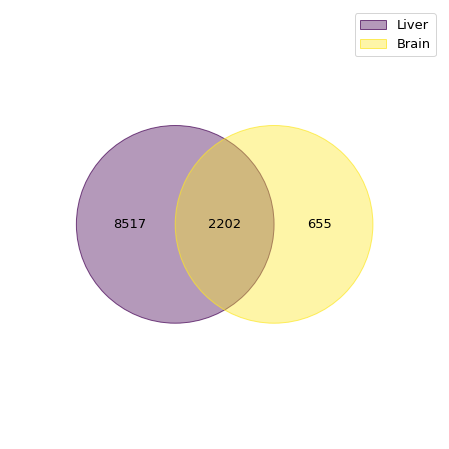

Transcript Overlap:


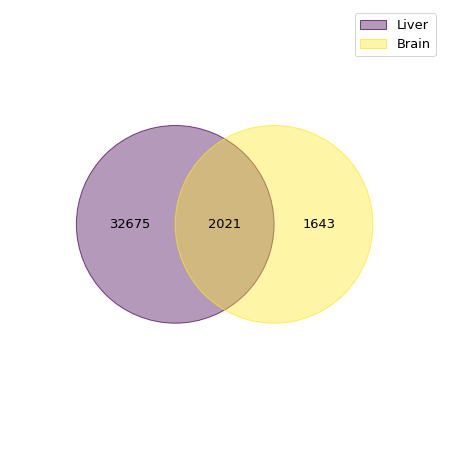

<Figure size 216x216 with 0 Axes>

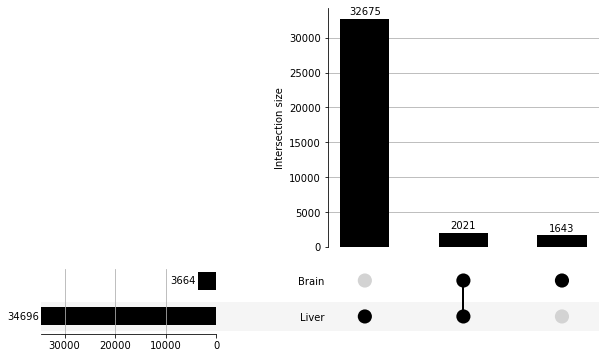

Beginning Single Exon Analysis:
Gene Overlap:


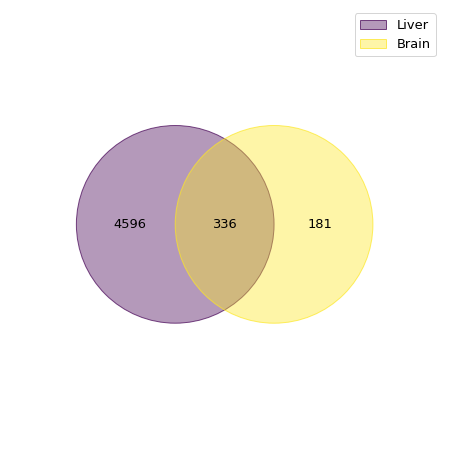

Transcript Overlap:


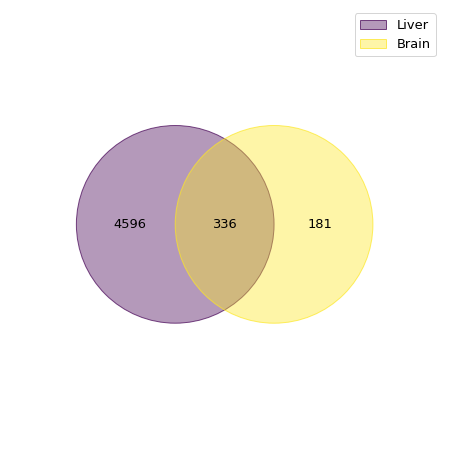

<Figure size 216x216 with 0 Axes>

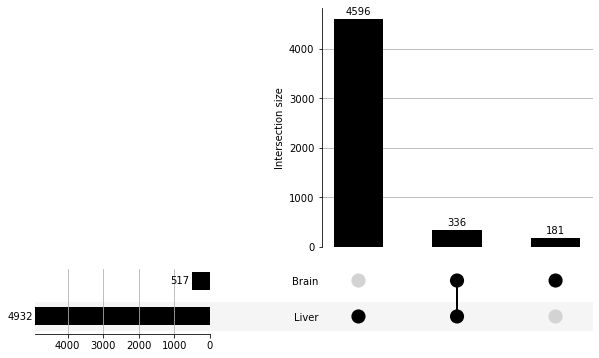

In [54]:
transcriptomeWithoutReference = gftTranscriptome([Brain, Liver],["Brain", "Liver"],  0, 100, oneExonSeperate = True)

***

## Building Transcriptome With A Reference

Combining:
Brain, Liver

Combining Dataframes:
6 + 6 - 2 + 2 - 20 + 20 - 14 + 14 - 16 + 16 - 3 + 3 - 9 + 9 - 1 + 1 - 4 + 4 - 7 + 7 - MT + MT - 12 + 12 - 11 + 11 - 10 + 10 - 8 + 8 - 5 + 5 - 19 + 19 - 13 + 13 - 18 + 18 - 17 + 17 - X + X - 15 + 15 - Y + Y - 

+-----------------+--------+
|       Name      | Amount |
+-----------------+--------+
|  Starting Size  | 48465  |
|    Final Size   | 41452  |
|  One Exon Size  |  5113  |
| Multi Exon Size | 36339  |
+-----------------+--------+
Creating Connections:
25% 50% 75% 100% 

Creating Genes:
25% 50% 75% 100% 

Number of Solitary Genes (One Exon): 5113
Number of Gene Networks (Multi Exon): 5991
Number of Solitary Genes (Multi Exon): 5383
Name: 
Type: Graph
Number of nodes: 30956
Number of edges: 418115
Average degree:  27.0135


Comparing to Reference:
6 + 6 - 2 + 2 - 20 + 20 - 14 + 14 - 16 + 16 - 3 + 3 - 9 + 9 - 1 + 1 - 4 + 4 - 7 + 7 - MT + MT - 12 + 12 - 11 + 11 - 10 + 10 - 8 + 8 - 5 + 5 - 19 + 19 - 13 + 13 - 18 + 18 - 17 + 17 - X + X -

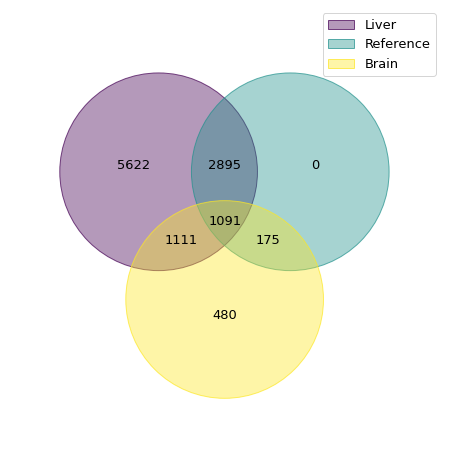

Transcript Overlap:


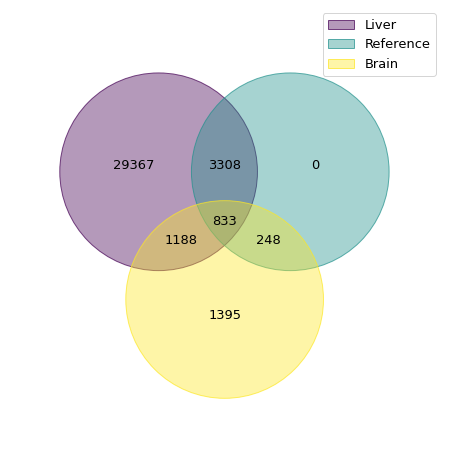

Gene Overlap:


FileNotFoundError: [Errno 2] No such file or directory: 'plots/multiGene.png'

<Figure size 216x216 with 0 Axes>

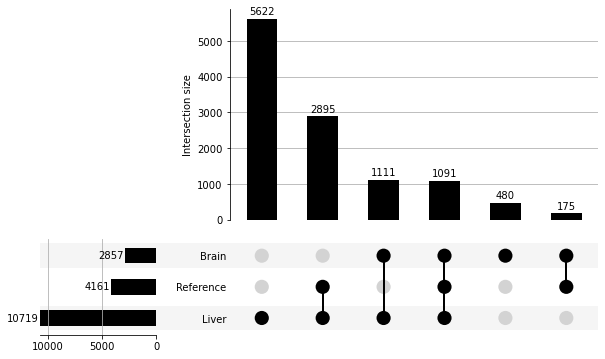

In [55]:
transcriptomeWithReference = gftTranscriptome([Brain, Liver],["Brain", "Liver"],  0, 100, Reference, "Reference", oneExonSeperate = True)

***

## Fusion Genes

In [ ]:
fusionGenes = findFusionGenes(transcriptomeFull, RattusRnor)

***

## Transcript Shape Comparison (Assembly vs Reference):

In [ ]:
smallLarger(transcriptomeFull, 0)

***

## Save Your Result

In [56]:
transcriptomeToSave = reformatExons(transcriptomeWithReference)

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 X Y 

In [ ]:
writeGTF(transcriptomeToSave, extraColumns = False)